In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

sns.set()

In this section, we load the RECS (Residential Energy Consumption Survey) dataset and remove columns associated with the "End-use Model" to avoid using derived features from other models.

In [2]:
recs_codebook_df = pd.read_csv('2020_RECS_Code_Book - codebook(1).csv', header=1)
print("Codebook loaded successfully.")

recs_df = pd.read_csv('recs2020_data.csv')
print("Data loaded successfully.")

Codebook loaded successfully.
Data loaded successfully.


In [3]:
recs_codebook_df.head()

,Comment,Include,Variable,Dtype,Type,Description and Labels,Response Codes,Section
0,UID,y,DOEID,num,Num,Unique identifier for each respondent,100001-118496,ADMIN
1,should we choose one?,y,REGIONC,cat,Char,Census Region,Midwest\nNortheast\nSouth\nWest,GEOGRAPHY
2,should we choose one?,n,DIVISION,NaN,Char,"Census Division, Mountain Division is divided ...",East North Central\nEast South Central\nMiddle...,GEOGRAPHY
3,"These are redundant, let's pick one",n,STATE_FIPS,NaN,Char,State Federal Information Processing System Code,state_dictionary!A1,GEOGRAPHY
4,NaN,y,state_postal,cat,Char,State Postal Code,state_dictionary!A1,GEOGRAPHY


In [4]:
# Filter for only single-family homes (attached and detached)
single_family_homes = recs_df[(recs_df['TYPEHUQ'] == 2) | (recs_df['TYPEHUQ'] == 3)]

# Function to convert floats to integers and preserve NaN
def convert_to_int(x):
    if isinstance(x, float):
        if np.isnan(x):
            return np.nan  # Preserve NaN
        else:
            return int(x)  # Convert float to integer
    return x

# Apply the conversion to all numeric values
single_family_homes = single_family_homes.applymap(convert_to_int)

# Now, select columns where 'Include' is 'y' or 'category'
cols_to_keep = recs_codebook_df[recs_codebook_df['Include'] == 'y']['Variable'].tolist()

# Select columns marked as 'outlier' to handle them separately
cols_to_fix = recs_codebook_df[(recs_codebook_df['Include'] == 'outlier') |
                              (recs_codebook_df['Include'] == 'category')]['Variable'].tolist()

# Create a subset of the dataframe with selected columns
df_y = single_family_homes[cols_to_keep]
df_f = single_family_homes[cols_to_fix]

print(f"Selected {len(cols_to_keep)} features for analysis.")
print(f"Selected {len(cols_to_fix)} features to update.")

Selected 49 features for analysis.
Selected 85 features to update.


In [5]:
# Handle outliers using .loc[] to avoid the SettingWithCopyWarning
df_f.loc[:, ['USEHUMID', 'H2OMAIN']] = df_f.loc[:, ['USEHUMID', 'H2OMAIN']].replace(99, 5)
df_f.loc[:, ['USECFAN', 'USEDEHUM']] = df_f.loc[:, ['USECFAN', 'USEDEHUM']].replace(99, 0)
df_f.loc[:, ['EQUIPM', 'EQUIPAUXTYPE']] = df_f.loc[:, ['EQUIPM', 'EQUIPAUXTYPE']].replace(99, 15)
df_f.loc[:, 'FUELAUX'] = df_f.loc[:, 'FUELAUX'].replace(99, 9)

# Replace values globally in df_f
df_f.replace(-2, 0, inplace=True)

# Now combine the cleaned 'outlier' columns with the main dataframe
subset_df = df_y.join(df_f)

# Checking the shape of the combined dataframe
print(subset_df.shape)

# Checking the number of missing values after combining
missing_values = subset_df.isnull().sum().sort_values(ascending=False)
print(missing_values)

(14070, 134)
MEDICALDEV    134
EVHOMEAMT       9
EVCHRGTYPE      8
NUMWWAC         0
COOLAPT         0
             ... 
SQFTEST         0
BACKUP          0
POWEROUT        0
LGTOUTANY       0
FUELPOOL        0
Length: 134, dtype: int64


/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_17638/1463169775.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f.replace(-2, 0, inplace=True)


In [6]:
# Calculate the number of non-missing values in each column
number_values = subset_df.count()

# Identify columns with more than 25% missing data
threshold = 0.75 * len(subset_df)
cols_to_drop = [col for col in subset_df.columns if subset_df[col].count() < threshold]

# Drop columns with too many missing values
subset_df = subset_df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns due to excessive missing data.")

# Recalculate the number of missing values
missing_percentage = subset_df.isnull().mean() * 100
print(f"Remaining missing data percentage: {missing_percentage.mean():.2f}%")

# Check the number of features with missing data
num_missing_cols = subset_df.columns[subset_df.isnull().any()].tolist()
print(f"There are {len(num_missing_cols)} features with missing data remaining.")


Dropped 0 columns due to excessive missing data.
Remaining missing data percentage: 0.01%
There are 3 features with missing data remaining.


In [7]:
subset_df = subset_df.dropna()
subset_df.head()

,DOEID,REGIONC,state_postal,BA_climate,UATYP10,HDD65,CDD65,HDD30YR_PUB,CDD30YR_PUB,KOWNRENT,...,NGPAY,LPGPAY,FOPAY,SMARTMETER,INTDATAACC,SOLAR,WOODTYPE,OUTLET,EVHOMEAMT,EVCHRGTYPE
0,100001,WEST,NM,Mixed-Dry,U,3844,1679,4451,1027,1,...,1,0,0,0,0,0,0,1,0.0,0.0
3,100004,SOUTH,SC,Mixed-Humid,U,2614,1718,3229,1653,1,...,1,0,0,1,0,0,0,1,0.0,0.0
5,100006,SOUTH,TX,Hot-Humid,U,901,3558,1150,3588,2,...,1,0,0,1,0,0,1,1,0.0,0.0
6,100007,SOUTH,OK,Mixed-Humid,U,3148,2128,3564,2043,2,...,1,0,0,1,0,0,0,1,0.0,0.0
10,100011,WEST,CA,Hot-Dry,U,1467,2108,1944,1747,1,...,1,0,0,1,0,1,0,1,0.0,0.0


In [8]:
numerical_cols = recs_codebook_df[recs_codebook_df['Type'] == 'Num']['Variable'].tolist()
categorical_cols = recs_codebook_df[recs_codebook_df['Type'] == 'Char']['Variable'].tolist()

numerical_cols = [col for col in numerical_cols if col in subset_df.columns]
categorical_cols = [col for col in categorical_cols if col in subset_df.columns]


In [9]:
subset_df[numerical_cols].head()

,DOEID,HDD65,CDD65,HDD30YR_PUB,CDD30YR_PUB,CELLAR,CRAWL,CONCRETE,BASEOTH,BASEFIN,...,BTUEL,DBT1,DBT99,BTUEL,GWT,WOODTYPE,OUTLET,ELECVEH,EVHOMEAMT,EVCHRGTYPE
0,100001,3844,1679,4451,1027,0,0,1,0,0,...,42723,92,21,42723,58,0,1,0,0.0,0.0
3,100004,2614,1718,3229,1653,0,1,0,0,0,...,31646,91,25,31646,61,0,1,0,0.0,0.0
5,100006,901,3558,1150,3588,0,0,1,0,0,...,48967,93,35,48967,72,1,1,0,0.0,0.0
6,100007,3148,2128,3564,2043,1,0,1,0,0,...,49406,96,18,49406,59,0,1,0,0.0,0.0
10,100011,1467,2108,1944,1747,0,0,1,0,0,...,26048,98,35,26048,62,0,1,0,0.0,0.0


In [10]:
# Normalize numerical columns using Min-Max scaling
scaler = MinMaxScaler()
subset_df[numerical_cols] = scaler.fit_transform(subset_df[numerical_cols])

print("Normalization of numerical data completed.")

Normalization of numerical data completed.


In [11]:
subset_df = pd.get_dummies(subset_df, columns=categorical_cols)

In [12]:
subset_df.head()

,DOEID,HDD65,CDD65,HDD30YR_PUB,CDD30YR_PUB,KOWNRENT,YEARMADERANGE,BEDROOMS,NCOMBATH,NHAFBATH,...,BA_climate_Hot-Dry,BA_climate_Hot-Humid,BA_climate_Marine,BA_climate_Mixed-Dry,BA_climate_Mixed-Humid,BA_climate_Subarctic,BA_climate_Very-Cold,UATYP10_C,UATYP10_R,UATYP10_U
0,0.000000,0.221136,0.303397,0.276958,0.209378,0.0,0.375,0.666667,0.75,0.0,...,False,False,False,True,False,False,False,False,False,True
3,0.000162,0.150377,0.310445,0.200921,0.337003,0.0,0.500,0.333333,0.50,0.5,...,False,False,False,False,True,False,False,False,False,True
5,0.000270,0.051832,0.642935,0.071557,0.731498,0.5,0.625,0.666667,0.50,0.5,...,False,True,False,False,False,False,False,False,False,True
6,0.000324,0.181096,0.384532,0.221766,0.416514,0.5,0.125,0.500000,0.50,0.0,...,False,False,False,False,True,False,False,False,False,True
10,0.000541,0.084393,0.380918,0.120963,0.356167,0.0,0.375,0.333333,0.50,0.0,...,True,False,False,False,False,False,False,False,False,True


In [13]:
# Perform PCA to capture 90% of the variance
pca = PCA(n_components=0.90, random_state=42)
pca_result = pca.fit_transform(subset_df)

print(f"PCA reduced the dataset to {pca_result.shape[1]} principal components.")


PCA reduced the dataset to 69 principal components.


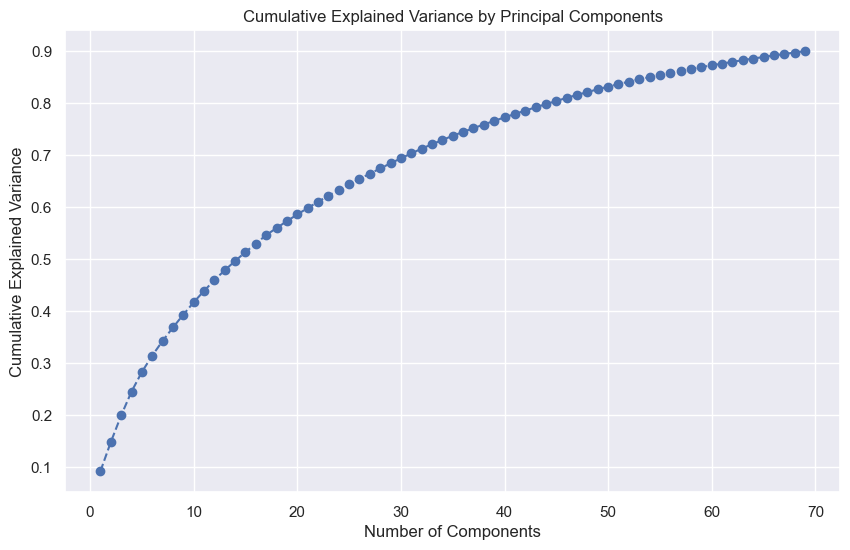

Number of components explaining at least 90% variance: 69


In [14]:
# Plot cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine the number of components that explain at least 90% of the variance
components_90_variance = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components explaining at least 90% variance: {components_90_variance}")

pca_90 = PCA(n_components=components_90_variance)
pca_90_result = pca_90.fit_transform(subset_df)

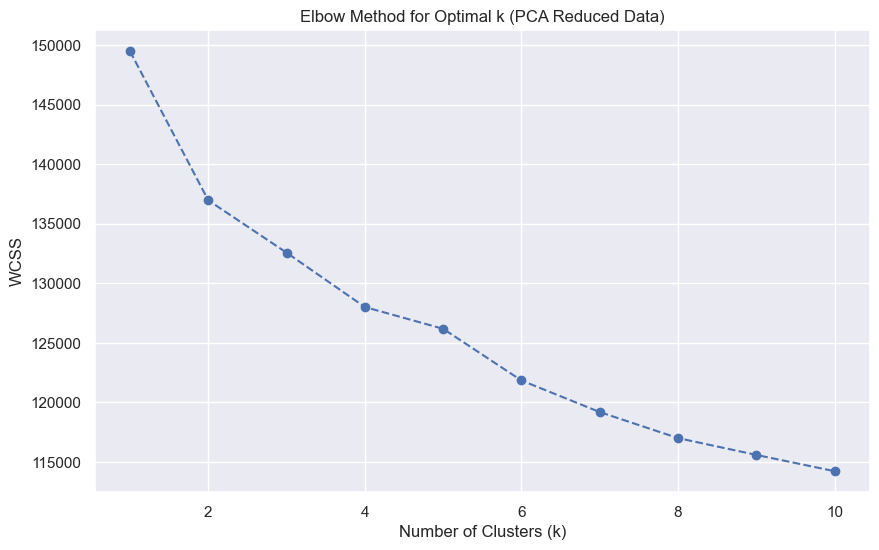

In [15]:
# Calculate WCSS (within-cluster sum of squares) for different values of k
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_90_result)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (PCA Reduced Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

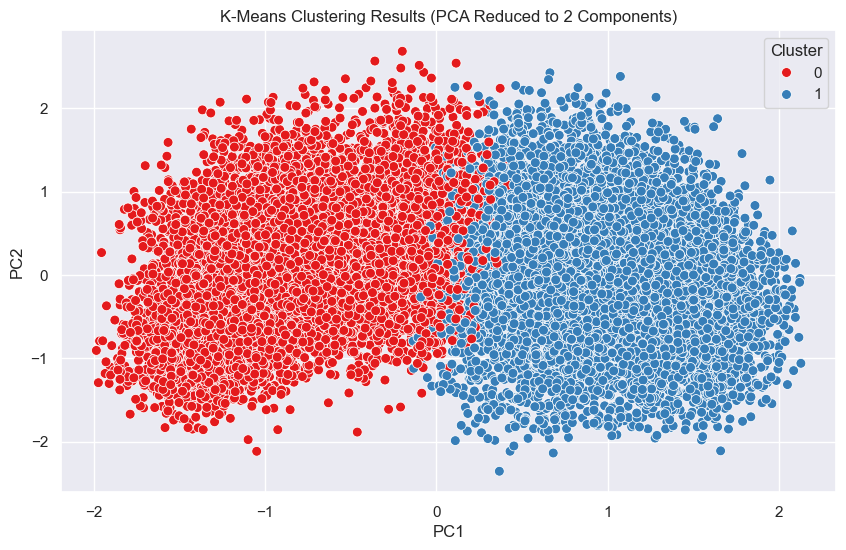

In [16]:
# Perform K-means clustering with the chosen k
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_90_result)

# Reduce to 2 components for visualization
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=50)
plt.title('K-Means Clustering Results (PCA Reduced to 2 Components)')
plt.show()

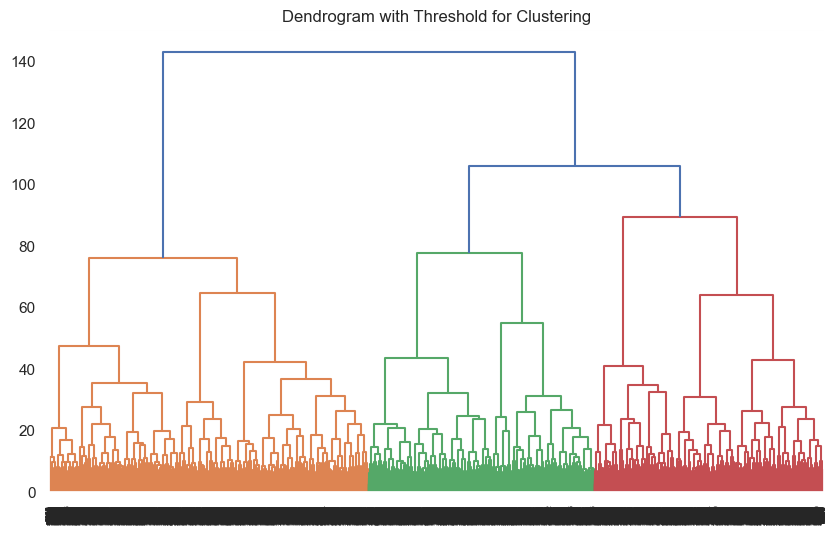

In [17]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Plot the Dendrogram with a threshold
plt.figure(figsize=(10, 6))
plt.title("Dendrogram with Threshold for Clustering")
dend = shc.dendrogram(shc.linkage(pca_90_result, method='ward'))
plt.show()

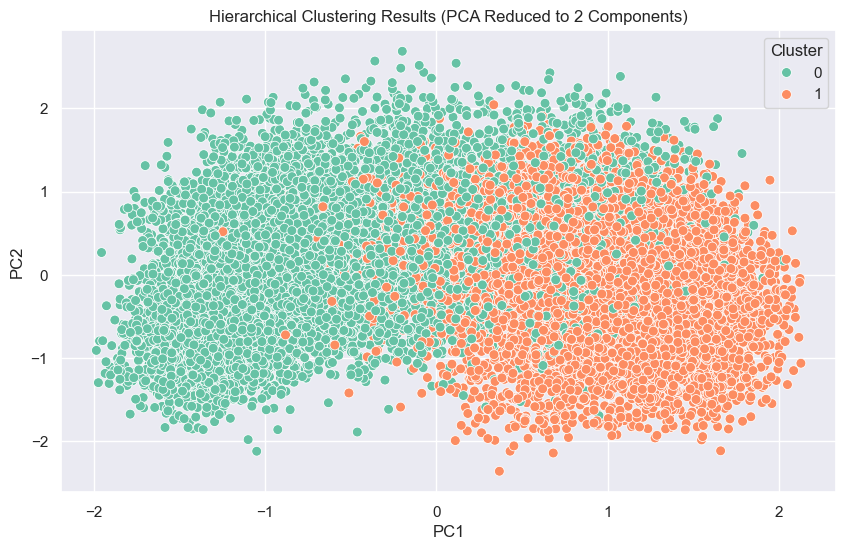

In [18]:
# Perform Hierarchical Clustering with chosen clusters
hierarchical = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(pca_90_result)  

# Visualize the clusters using the first two PCA components
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pca_90_result)

# Create a dataframe for the 2D PCA results
pca_df = pd.DataFrame(data=pca_2_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = hierarchical_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=50)
plt.title('Hierarchical Clustering Results (PCA Reduced to 2 Components)')
plt.show()

We begin by generating summary statistics for each cluster. This will give us an understanding of the average values, medians, and ranges of key features for each cluster.

In [19]:
# Generate summary statistics for each cluster (numerical columns only)
def get_cluster_summary(data, cluster_labels):
    data['Cluster'] = cluster_labels
    # Select only numerical columns
    numeric_data = data.select_dtypes(include=[np.number])
    summary = numeric_data.groupby('Cluster').agg(['mean', 'median', 'min', 'max'])
    return summary

# Apply to K-means clusters
kmeans_summary = get_cluster_summary(subset_df.copy(), kmeans_labels)
print(kmeans_summary)

            DOEID                                   HDD65                      \
             mean    median       min       max      mean    median       min   
Cluster                                                                         
0        0.503976  0.504569  0.000000  1.000000  0.179766  0.158373  0.000000   
1        0.500026  0.503596  0.000703  0.999838  0.333208  0.327849  0.050394   

                      CDD65            ... OUTLET      EVHOMEAMT              \
              max      mean    median  ...    min  max      mean median  min   
Cluster                                ...                                     
0        0.993154  0.360584  0.307192  ...    0.0  1.0  0.005844    0.0  0.0   
1        1.000000  0.165611  0.162089  ...    0.0  1.0  0.004171    0.0  0.0   

             EVCHRGTYPE                   
         max       mean median  min  max  
Cluster                                   
0        1.0   0.013331    0.0  0.0  1.0  
1        1.0   0.0103

In [20]:
# Frequency analysis for categorical columns
def get_categorical_frequency(data, cluster_labels):
    # Add the 'Cluster' column to the full dataframe
    data['Cluster'] = cluster_labels
    
    # Include 'Cluster' in the dataset explicitly
    categorical_data = data.select_dtypes(include=['object', 'category', 'bool']).copy()
    
    # Add back the 'Cluster' column since it might get excluded from filtering
    categorical_data['Cluster'] = data['Cluster']
    
    # Calculate the frequency
    frequency = categorical_data.groupby('Cluster').apply(lambda x: x.apply(pd.Series.value_counts))
    
    return frequency

# Apply to K-means clusters
# kmeans_categorical_frequency = get_categorical_frequency(subset_df.copy(), kmeans_labels)
# print(kmeans_categorical_frequency)

# Apply to hierarchical clusters
hierarchical_categorical_frequency = get_categorical_frequency(subset_df.copy(), hierarchical_labels)
print('\n\n\n', hierarchical_categorical_frequency)





                REGIONC_MIDWEST  REGIONC_NORTHEAST  REGIONC_SOUTH  \
Cluster                                                            
0       False             7323               7815           4144   
        True               852                360           4031   
1       False             3538               3521           4974   
        True              2214               2231            778   

               REGIONC_WEST  state_postal_AK  state_postal_AL  \
Cluster                                                         
0       False          5243             7931             8016   
        True           2932              244              159   
1       False          5223             5750             5734   
        True            529                2               18   

               state_postal_AR  state_postal_AZ  state_postal_CA  \
Cluster                                                            
0       False             7969             7788             

In [21]:
from sklearn.ensemble import RandomForestClassifier
importances = []

# Fit a RandomForest to the clustered data to understand feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(subset_df, kmeans_labels)

# Get feature importance
importances = rf.feature_importances_

# Match importance to feature names
feature_importance_df = pd.DataFrame({'Feature': subset_df.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Top Features Driving Cluster Separation:\n", feature_importance_df.head(10))


Top Features Driving Cluster Separation:
              Feature  Importance
46            CELLAR    0.200572
78          BASEHEAT    0.128124
50           BASEFIN    0.062110
90          BASECOOL    0.060346
41             DBT99    0.053086
1              HDD65    0.047332
108          H2OMAIN    0.046748
3        HDD30YR_PUB    0.037666
43               GWT    0.036058
185  BA_climate_Cold    0.027358


In [22]:
from scipy.stats import zscore

# Calculate Z-scores for each cluster for numerical columns
def cluster_profiling(data, cluster_labels):
    data['Cluster'] = cluster_labels
    numeric_data = data.select_dtypes(include=[np.number])

    # Group by cluster and calculate z-scores to identify the most distinct features
    z_scores = numeric_data.groupby('Cluster').apply(lambda x: zscore(x, nan_policy='omit'))

    # Ensure 'Cluster' is not both in the index and columns
    z_scores.reset_index(drop=True, inplace=True)

    # Calculate the means and Z-scores of features across clusters
    cluster_means = numeric_data.groupby('Cluster').mean()
    
    # Identify the most distinctive features for each cluster
    distinctive_features = z_scores.abs().groupby(data['Cluster']).mean()

    # Sort by the most distinctive feature by mean Z-score for each cluster
    distinctive_features_sorted = distinctive_features.mean(axis=1).sort_values(ascending=False)
    
    return cluster_means, distinctive_features_sorted

# Apply to K-means clusters
kmeans_means, kmeans_distinctive_features = cluster_profiling(subset_df.copy(), kmeans_labels)

print("K-Means Cluster Means:\n", kmeans_means)
print("\nMost Distinctive Features in Each K-Means Cluster:\n", kmeans_distinctive_features)


K-Means Cluster Means:
             DOEID     HDD65     CDD65  HDD30YR_PUB  CDD30YR_PUB  KOWNRENT  \
Cluster                                                                     
0        0.503976  0.179766  0.360584     0.217801     0.351912  0.091936   
1        0.500026  0.333208  0.165611     0.388009     0.157707  0.044274   

         YEARMADERANGE  BEDROOMS  NCOMBATH  NHAFBATH  ...     NGPAY    LPGPAY  \
Cluster                                               ...                       
0             0.487523  0.512980  0.482270  0.178290  ...  0.006609  0.032922   
1             0.369990  0.560827  0.495248  0.265009  ...  0.007663  0.047310   

            FOPAY  SMARTMETER  INTDATAACC     SOLAR  WOODTYPE    OUTLET  \
Cluster                                                                   
0        0.000504    0.547833    0.106120  0.050039  0.058117  0.739821   
1        0.001365    0.546967    0.080469  0.038967  0.085934  0.790274   

         EVHOMEAMT  EVCHRGTYPE  
Cluster 

In [23]:
# Create a contingency table for each categorical variable
def contingency_tables(data, cluster_labels):
    data['Cluster'] = cluster_labels
    categorical_data = data.select_dtypes(include=['object', 'category', 'bool'])
    
    tables = {}
    for col in categorical_data.columns:
        table = pd.crosstab(data[col], data['Cluster'], normalize='columns')  # Proportions within clusters
        tables[col] = table
    
    return tables

# Get contingency tables for K-means clusters
contingency_tables_kmeans = contingency_tables(subset_df.copy(), kmeans_labels)

contingency_tables_kmeans

{'REGIONC_MIDWEST': Cluster                 0        1
 REGIONC_MIDWEST                   
 False            0.923037  0.60716
 True             0.076963  0.39284,
 'REGIONC_NORTHEAST': Cluster                   0         1
 REGIONC_NORTHEAST                    
 False              0.951405  0.648186
 True               0.048595  0.351814,
 'REGIONC_SOUTH': Cluster               0         1
 REGIONC_SOUTH                    
 False          0.474127  0.872485
 True           0.525873  0.127515,
 'REGIONC_WEST': Cluster              0         1
 REGIONC_WEST                    
 False         0.651432  0.872169
 True          0.348568  0.127831,
 'state_postal_AK': Cluster                 0         1
 state_postal_AK                    
 False            0.975046  0.991129
 True             0.024954  0.008871,
 'state_postal_AL': Cluster                 0         1
 state_postal_AL                    
 False            0.979117  0.997149
 True             0.020883  0.002851,
 'state_pos

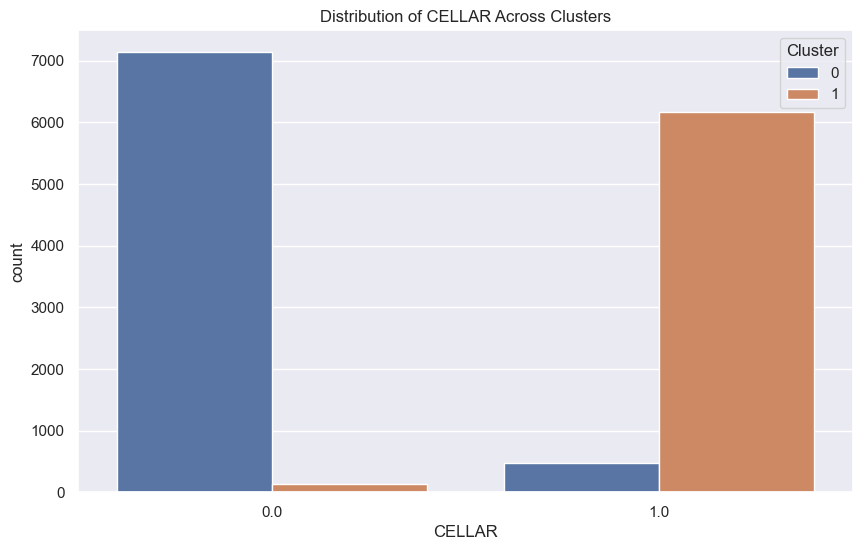

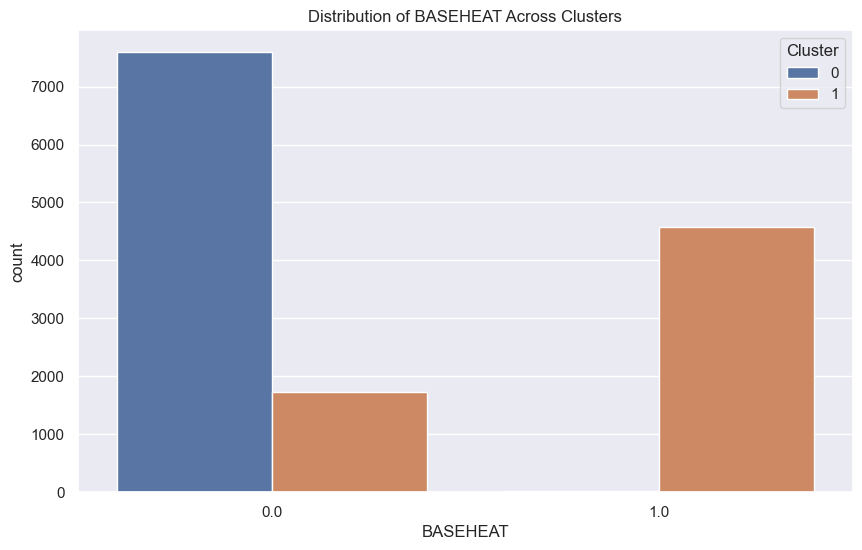

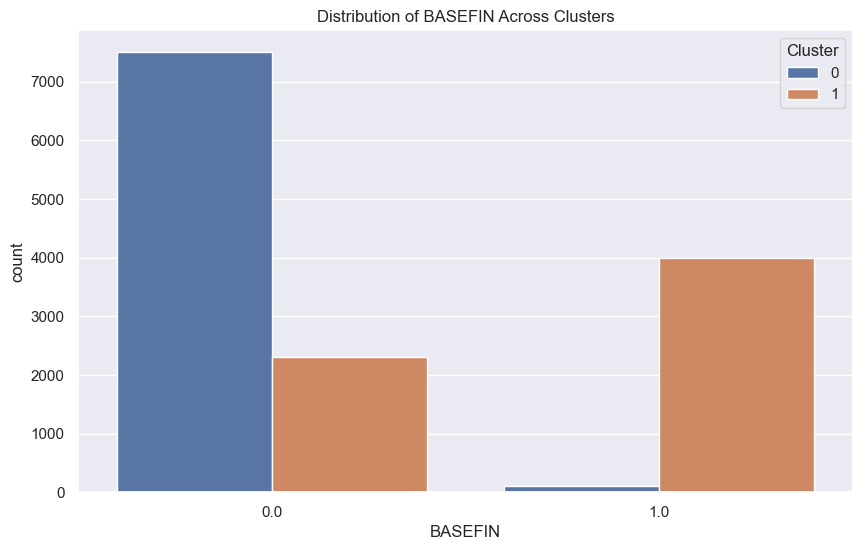

In [24]:
# Visualize the distribution of categorical variables across clusters
def plot_categorical_distributions(data, cluster_labels, categorical_cols):
    data['Cluster'] = cluster_labels
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='Cluster', data=data)
        plt.title(f'Distribution of {col} Across Clusters')
        plt.show()

# List of categorical columns to plot
categorical_cols = ['CELLAR', 'BASEHEAT', 'BASEFIN']

# Plot distributions for K-means clusters
plot_categorical_distributions(subset_df.copy(), kmeans_labels, categorical_cols)

In [25]:
def get_modes_per_cluster_onehot(data, cluster_labels):
    data['Cluster'] = cluster_labels
    # Select all binary columns (assuming one-hot encoding produces binary columns)
    binary_data = data.select_dtypes(include=[np.number])
    modes = binary_data.groupby('Cluster').agg(lambda x: x.mode()[0])
    return modes

# Get the mode for K-means clusters in the one-hot encoded data
modes_kmeans = get_modes_per_cluster_onehot(subset_df.copy(), kmeans_labels)
print("Mode of One-Hot Encoded Variables per K-Means Cluster:\n", modes_kmeans)

Mode of One-Hot Encoded Variables per K-Means Cluster:
             DOEID     HDD65     CDD65  HDD30YR_PUB  CDD30YR_PUB  KOWNRENT  \
Cluster                                                                     
0        0.000000  0.000000  0.000181     0.000000          0.0       0.0   
1        0.000703  0.346948  0.000181     0.361085          0.0       0.0   

         YEARMADERANGE  BEDROOMS  NCOMBATH  NHAFBATH  ...     NGPAY  LPGPAY  \
Cluster                                               ...                     
0                 0.75       0.5       0.5       0.0  ...  0.010101     0.0   
1                 0.00       0.5       0.5       0.0  ...  0.010101     0.0   

         FOPAY  SMARTMETER  INTDATAACC  SOLAR  WOODTYPE  OUTLET  EVHOMEAMT  \
Cluster                                                                      
0          0.0         0.0         0.0    0.0       0.0     1.0        0.0   
1          0.0         0.0         0.0    0.0       0.0     1.0        0.0   

     

In [26]:
# Apply to hierarchical clusters
hierarchical_summary = get_cluster_summary(subset_df.copy(), hierarchical_labels)
print(hierarchical_summary)

            DOEID                                   HDD65                      \
             mean    median       min       max      mean    median       min   
Cluster                                                                         
0        0.503426  0.504082  0.000000  1.000000  0.195721  0.169131  0.000000   
1        0.500422  0.504190  0.000703  0.999838  0.325497  0.319881  0.070299   

                     CDD65            ... OUTLET      EVHOMEAMT              \
             max      mean    median  ...    min  max      mean median  min   
Cluster                               ...                                     
0        1.00000  0.341145  0.291110  ...    0.0  1.0  0.005484    0.0  0.0   
1        0.81177  0.174222  0.168052  ...    0.0  1.0  0.004520    0.0  0.0   

             EVCHRGTYPE                   
         max       mean median  min  max  
Cluster                                   
0        1.0   0.012783    0.0  0.0  1.0  
1        1.0   0.010866   

In [27]:
kmeans_means, kmeans_distinctive_features = cluster_profiling(subset_df.copy(), kmeans_labels)
print("Most Distinctive Features in Each K-Means Cluster:\n", kmeans_distinctive_features)


Most Distinctive Features in Each K-Means Cluster:
 Cluster
0.0    0.649918
1.0    0.649382
dtype: float64


In [28]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(pca_90_result, kmeans_labels)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.08233071762930076


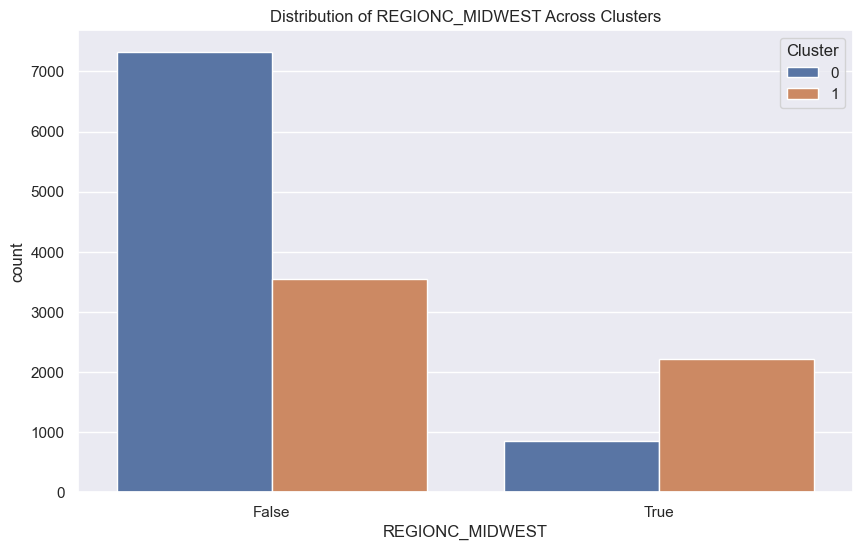

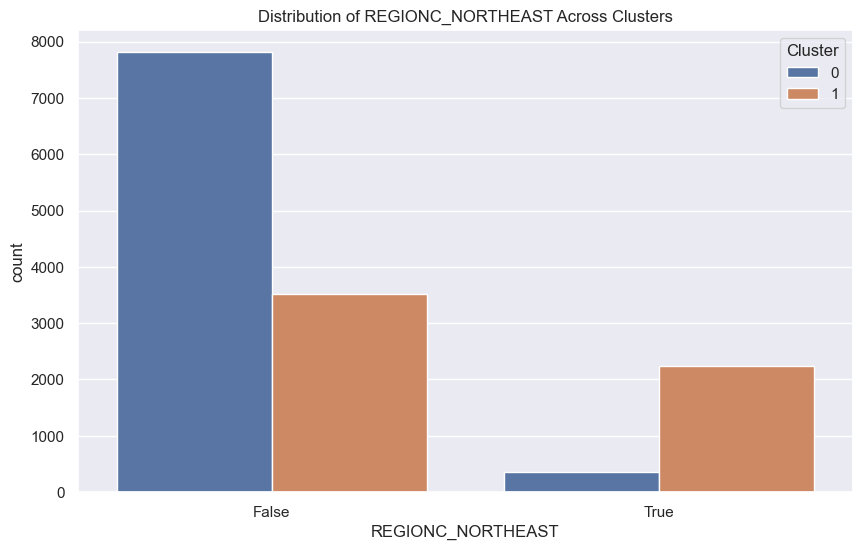

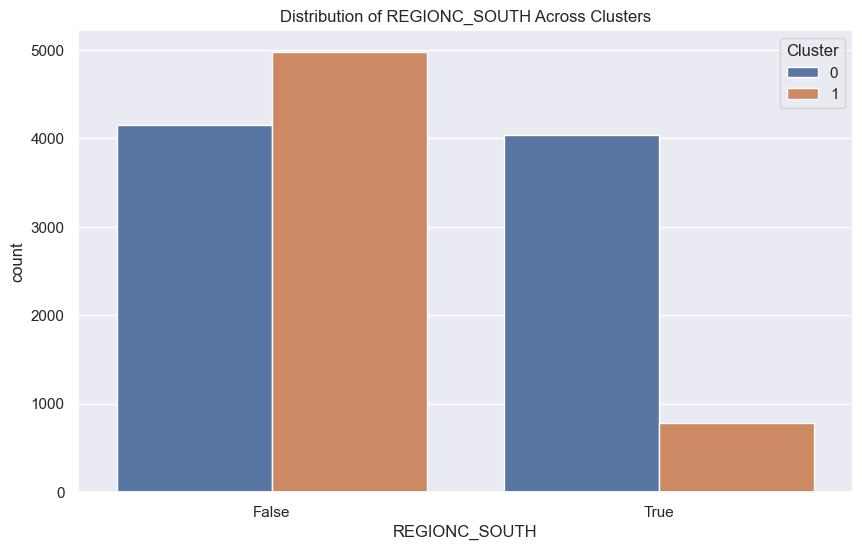

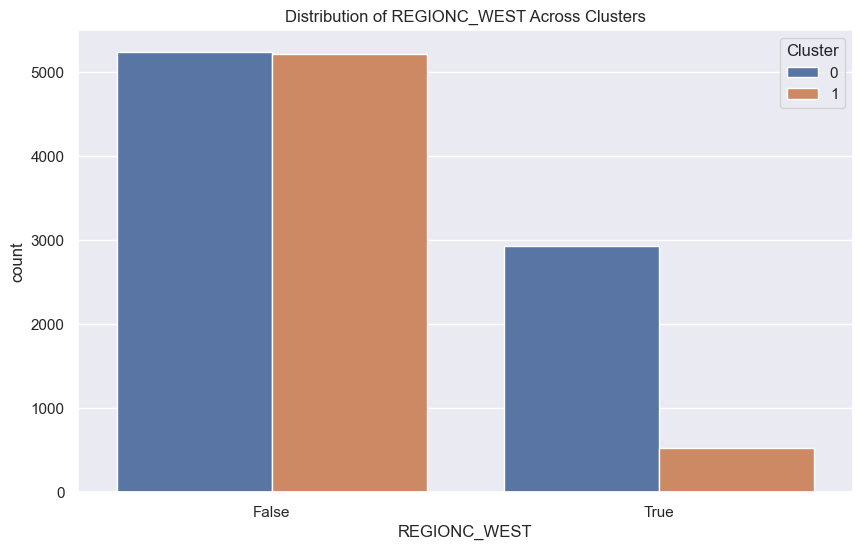

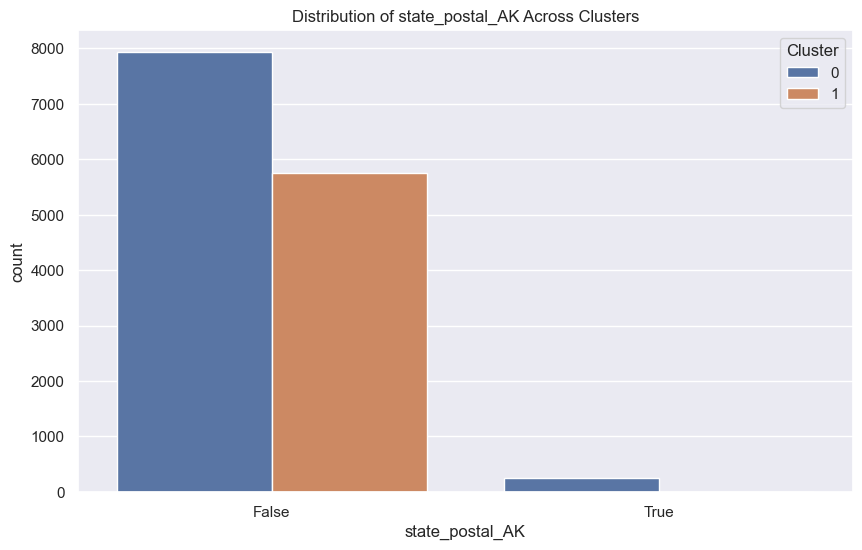

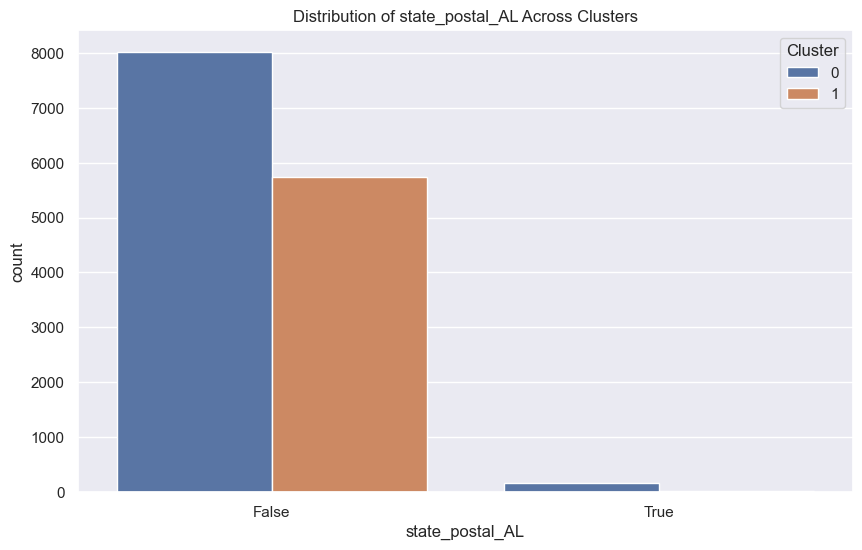

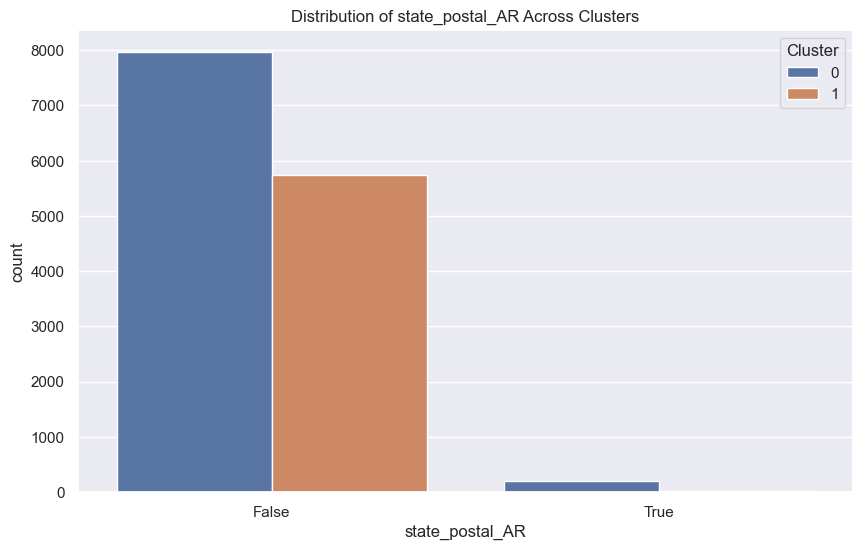

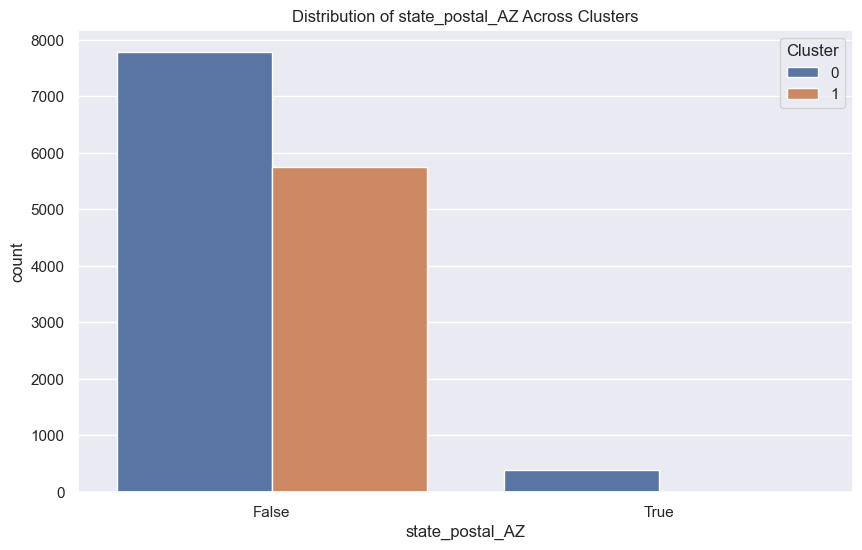

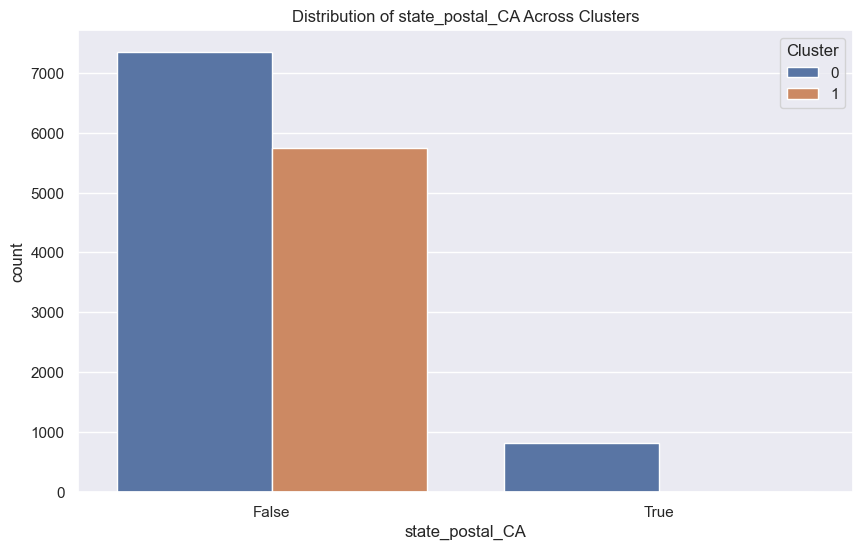

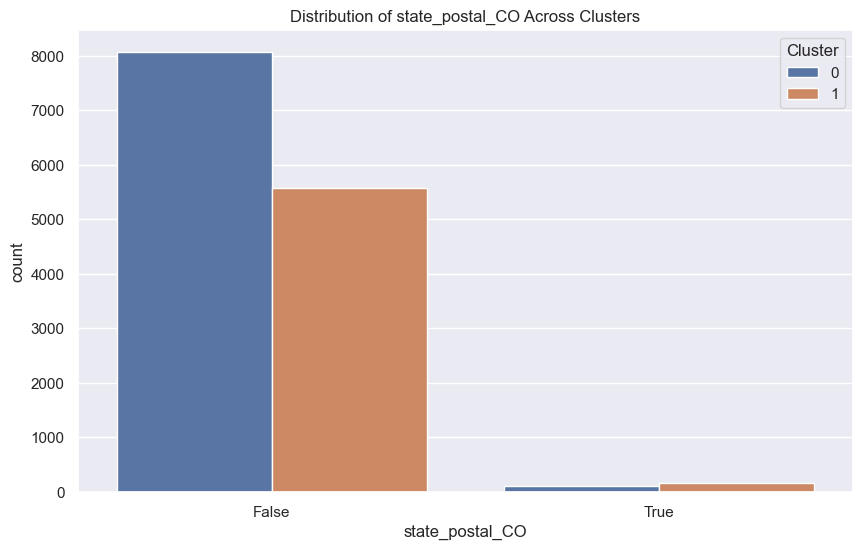

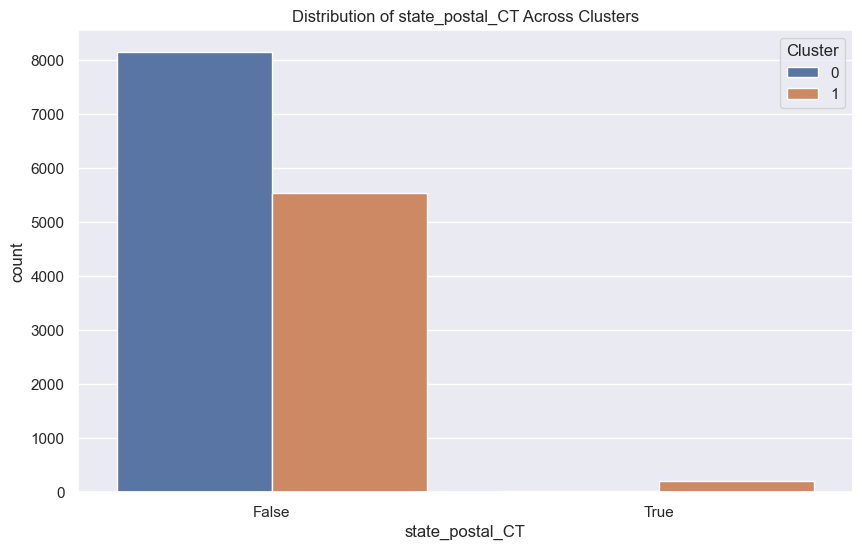

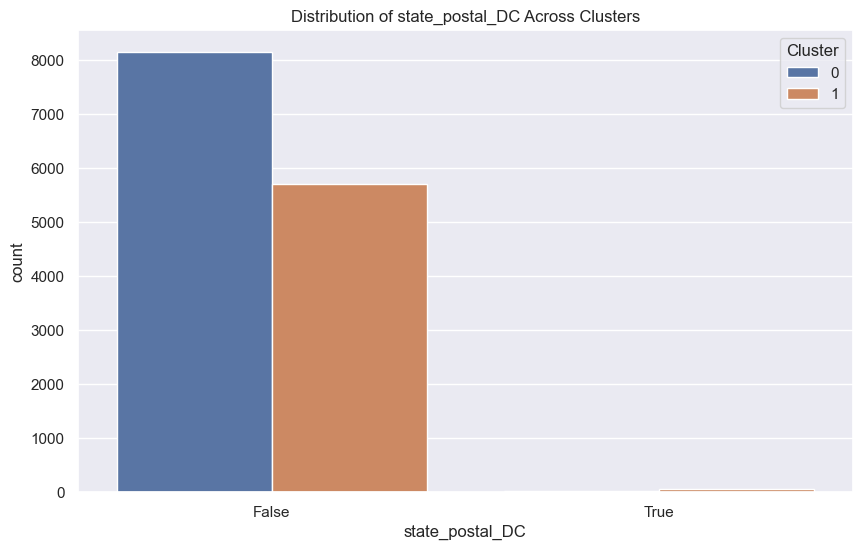

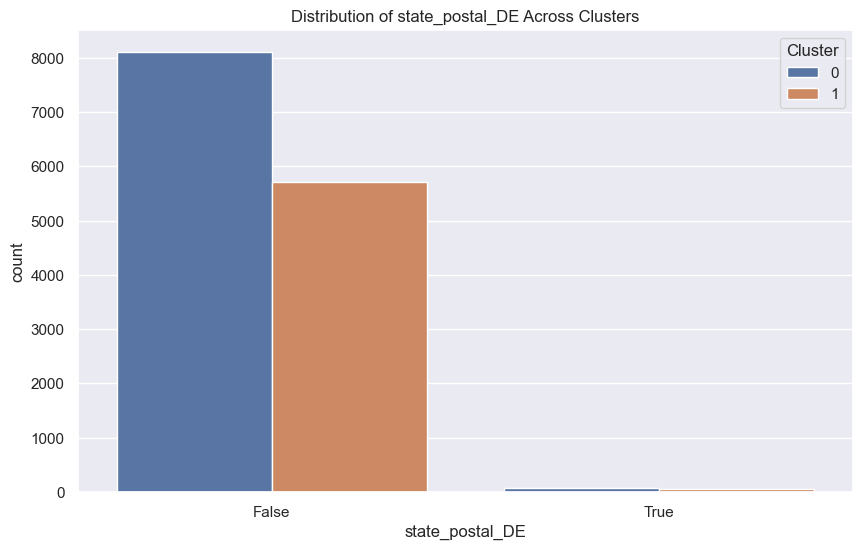

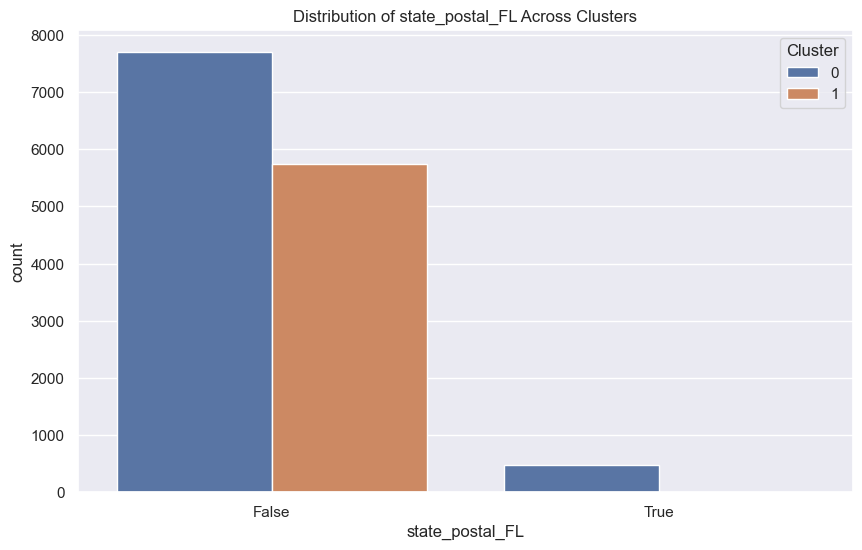

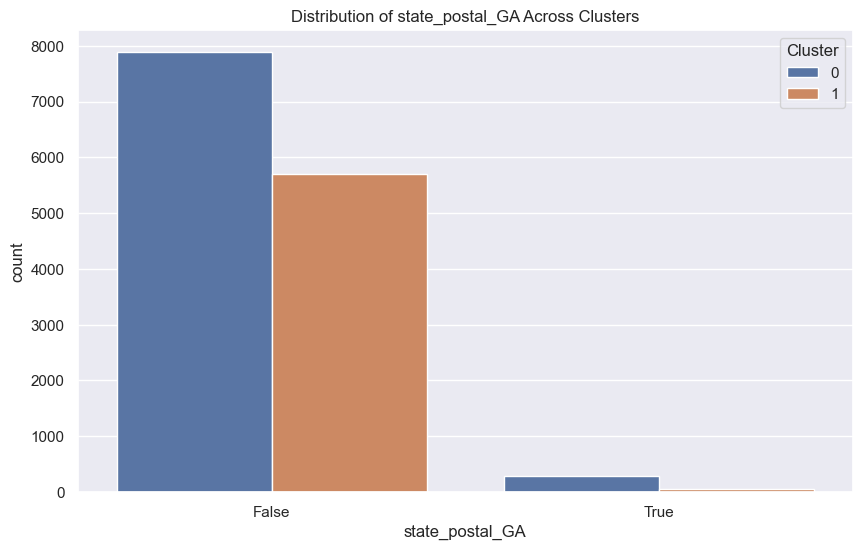

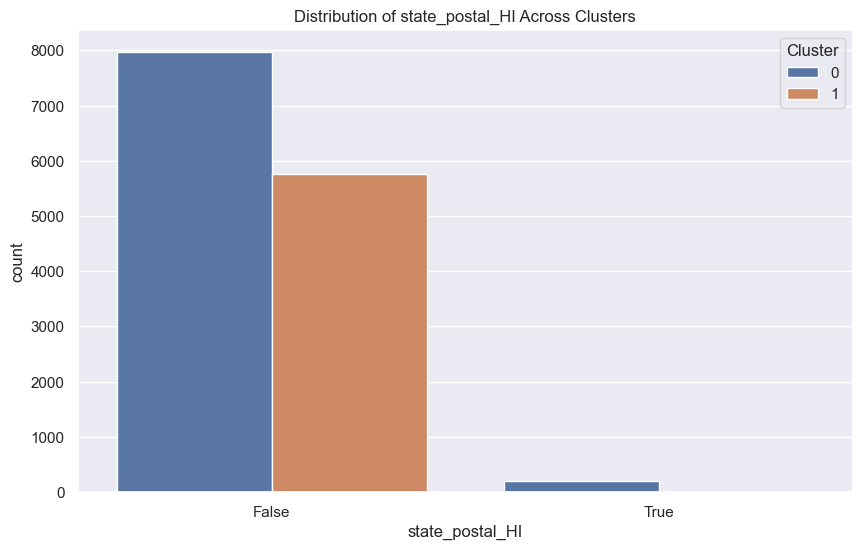

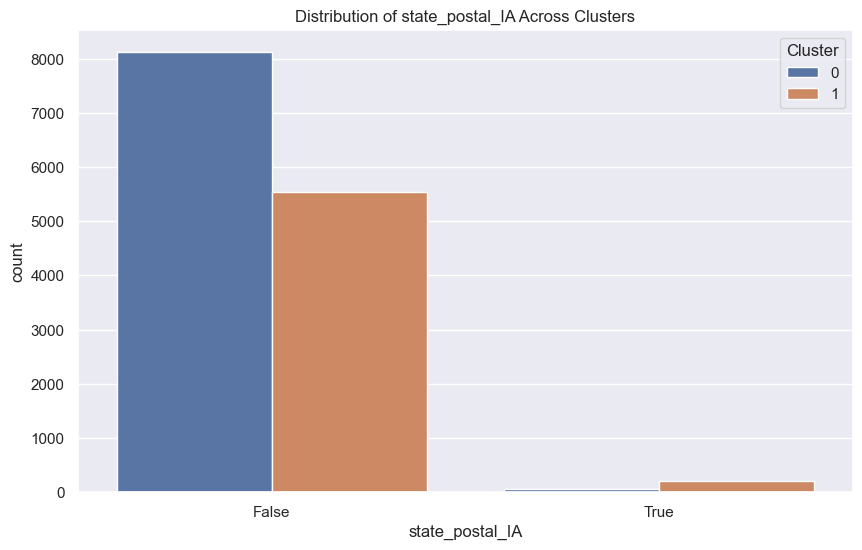

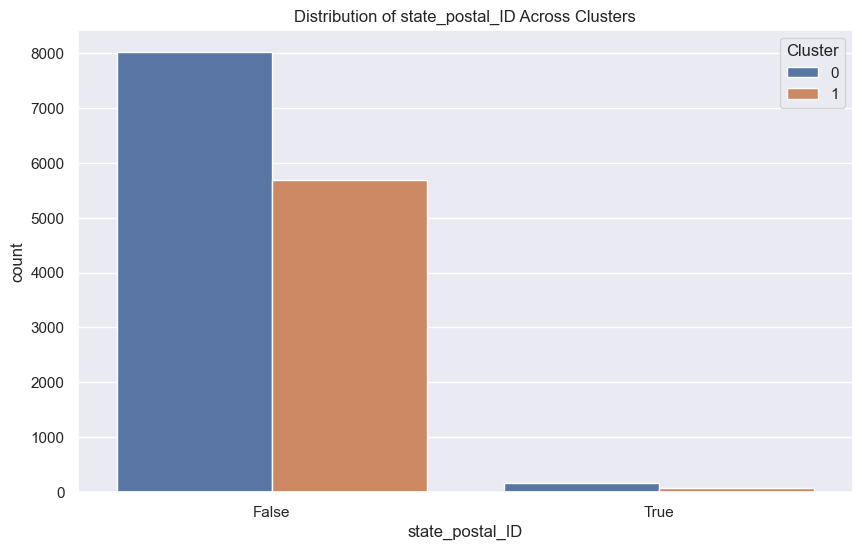

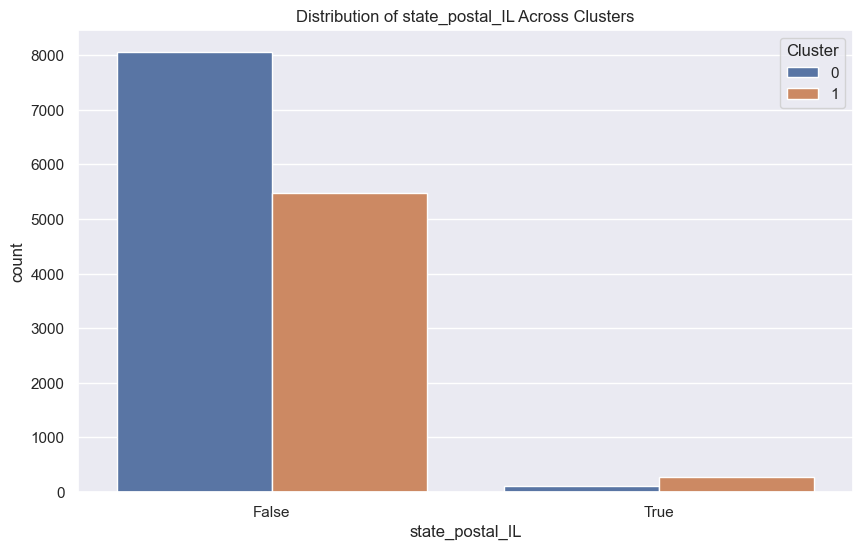

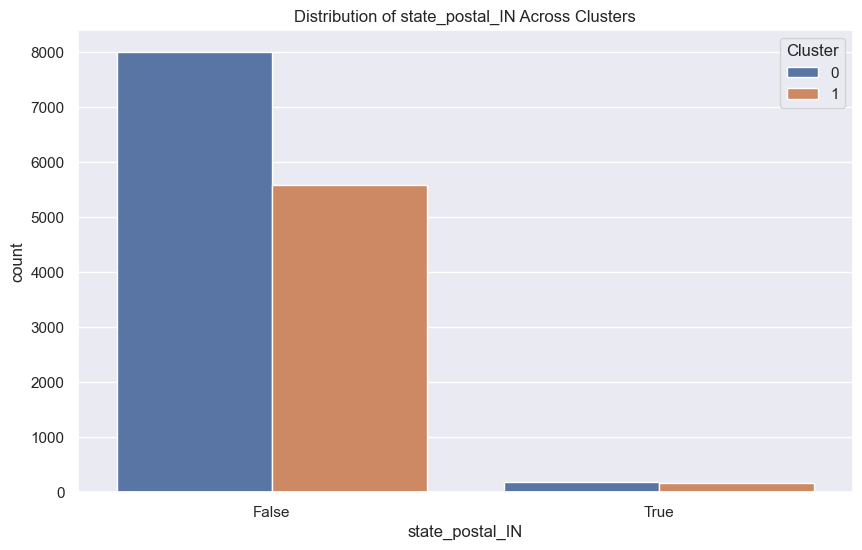

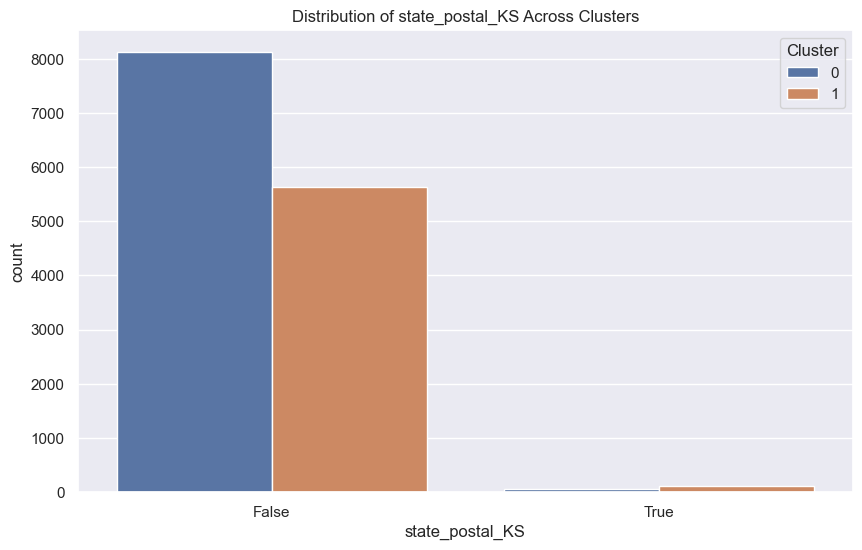

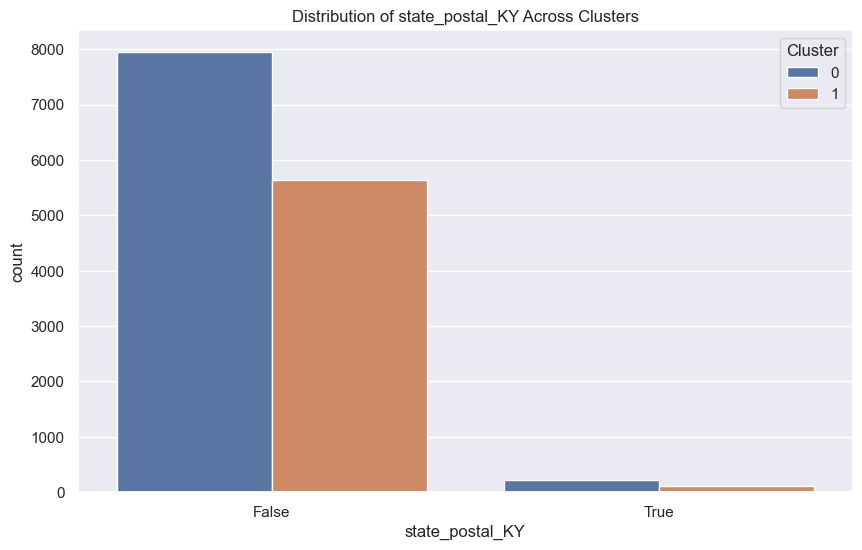

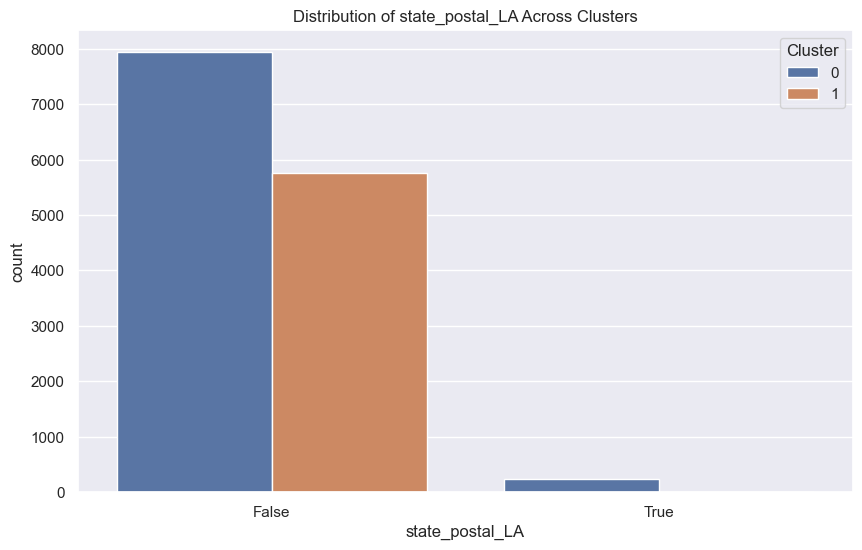

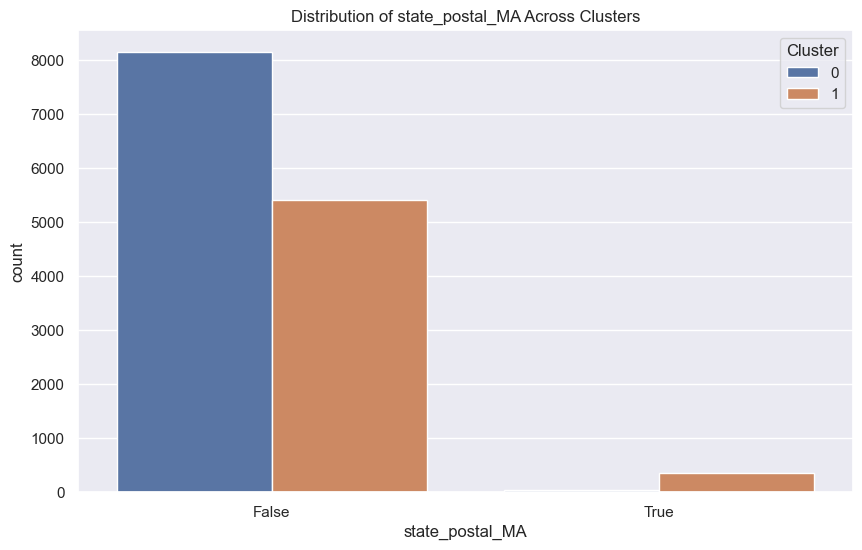

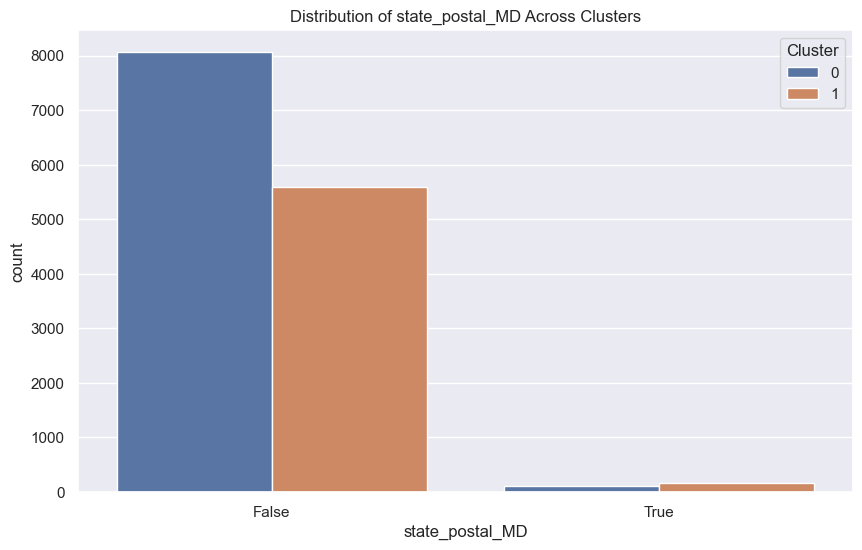

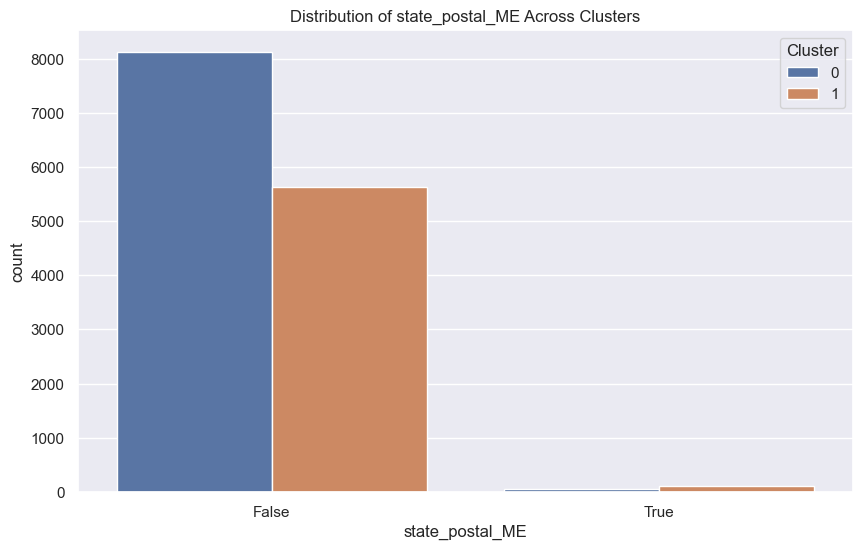

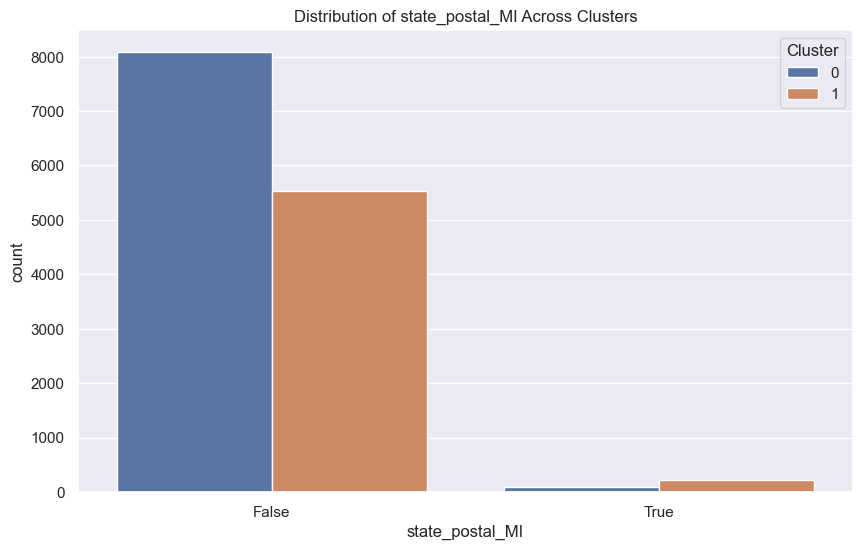

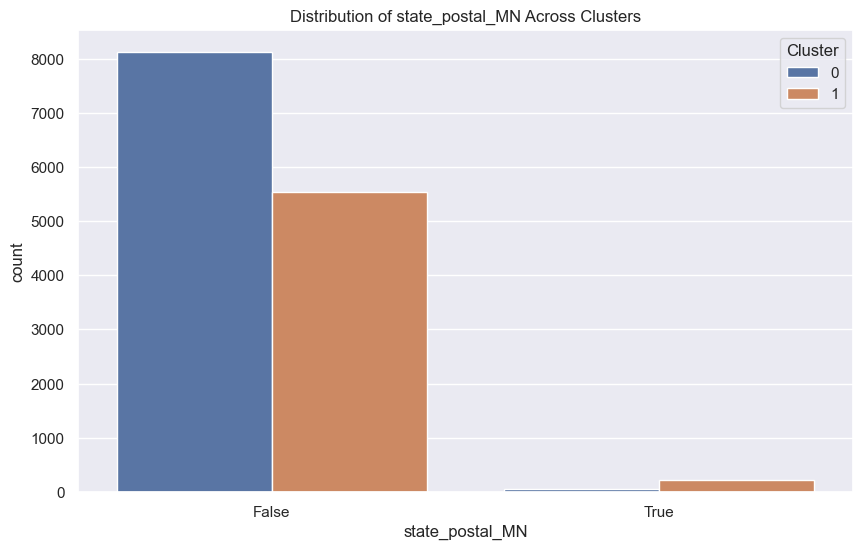

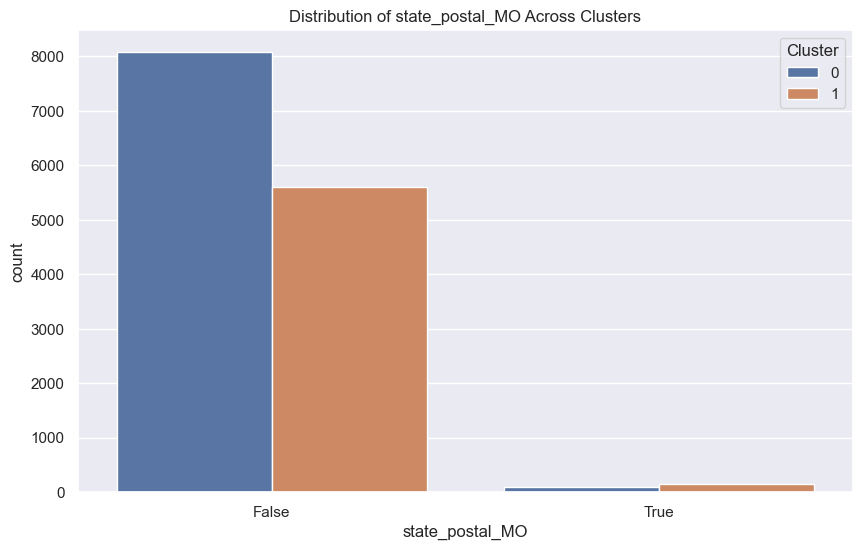

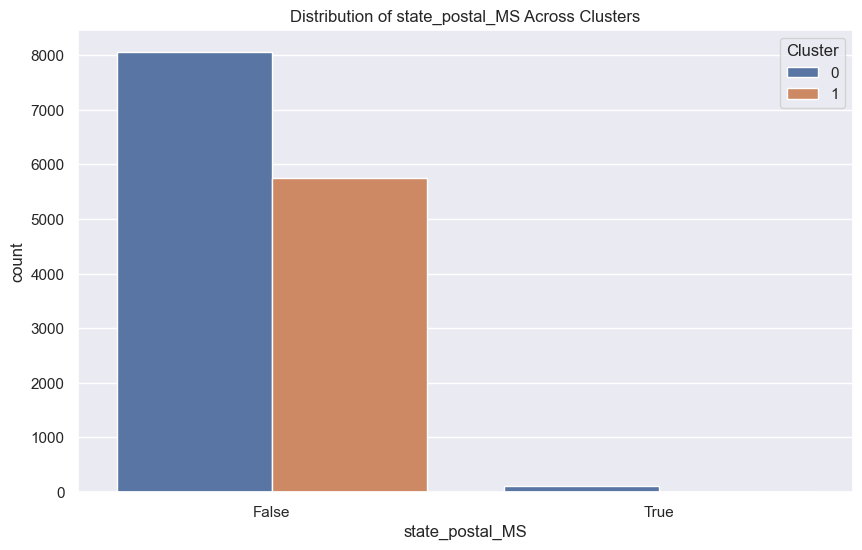

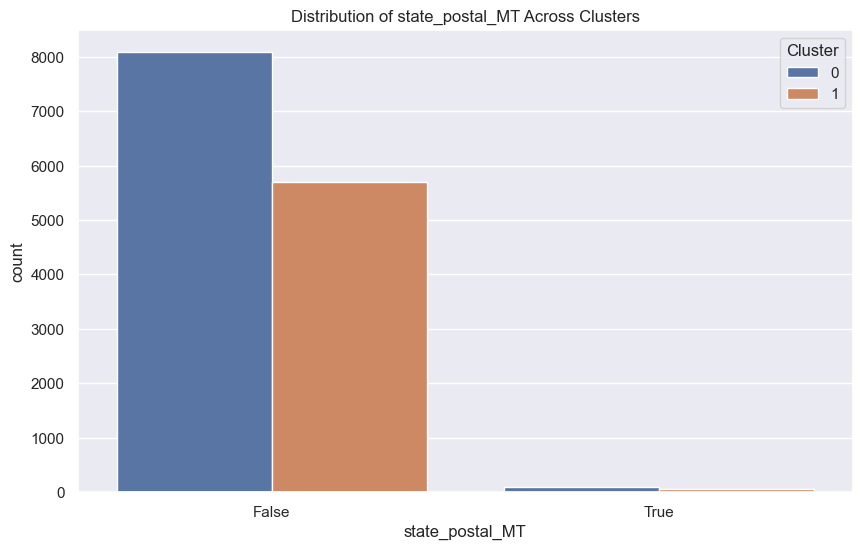

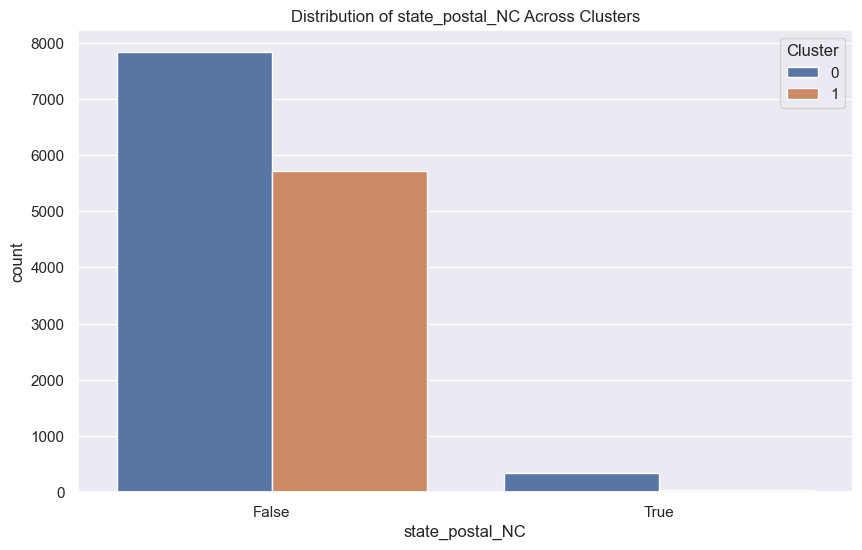

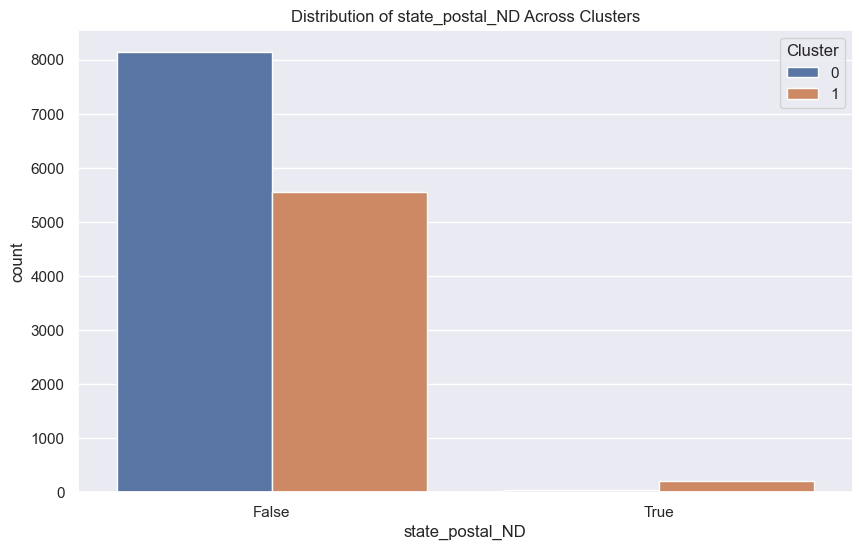

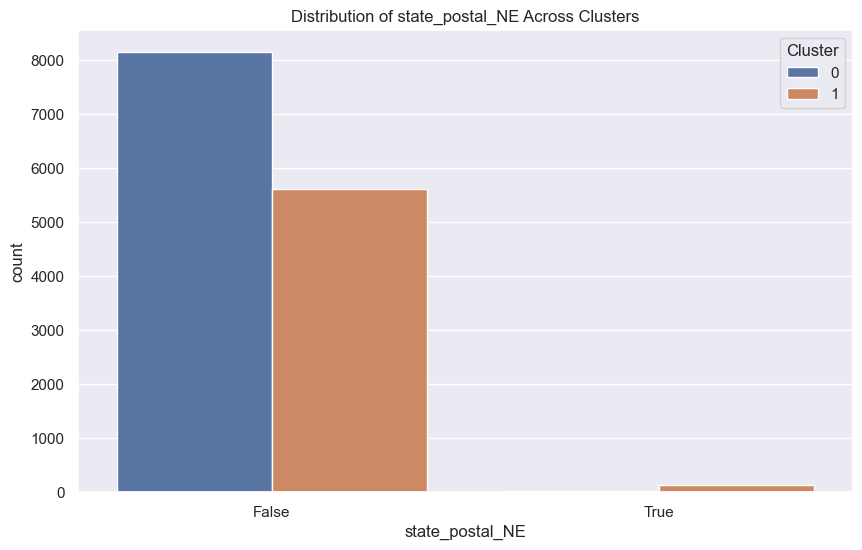

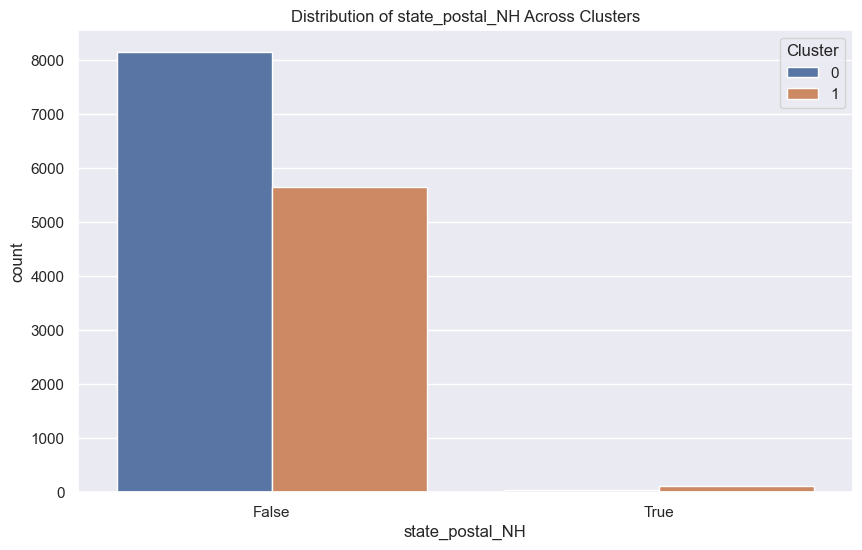

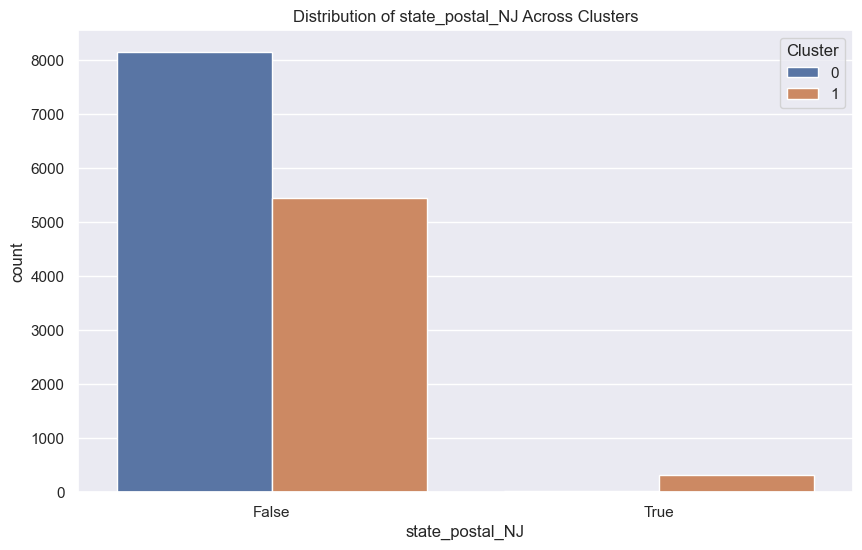

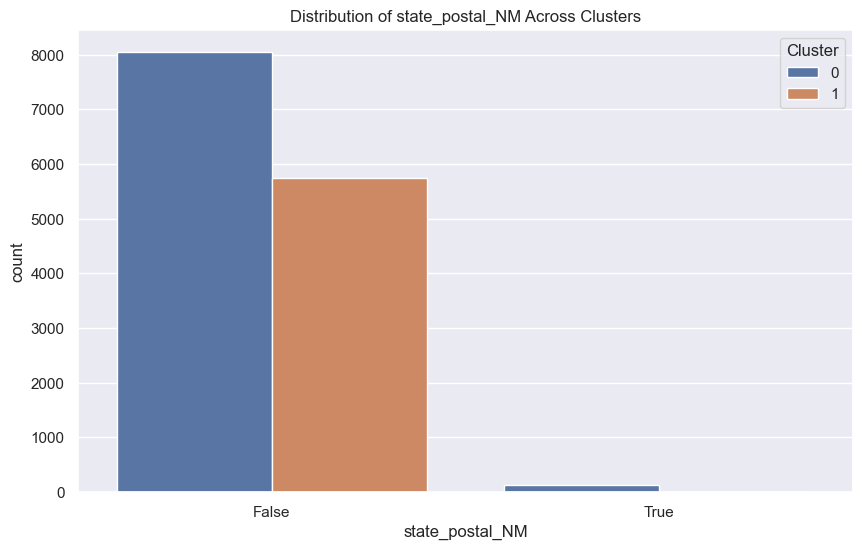

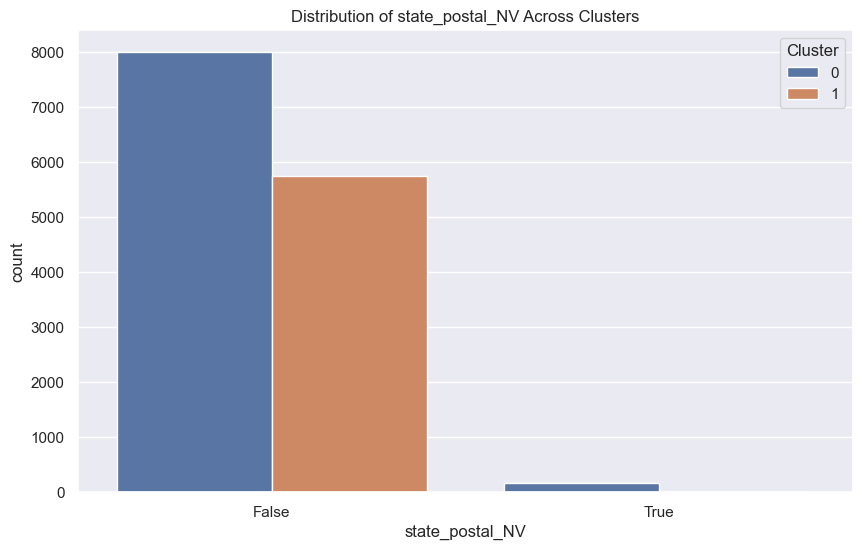

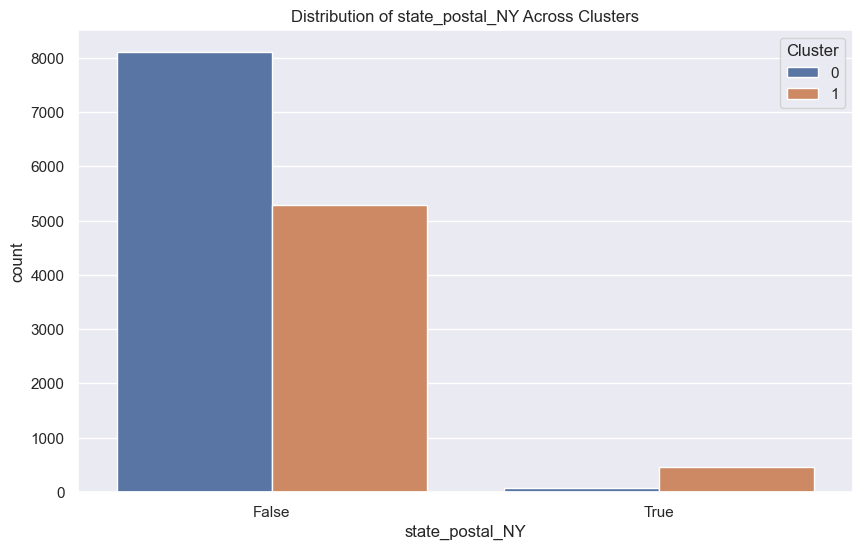

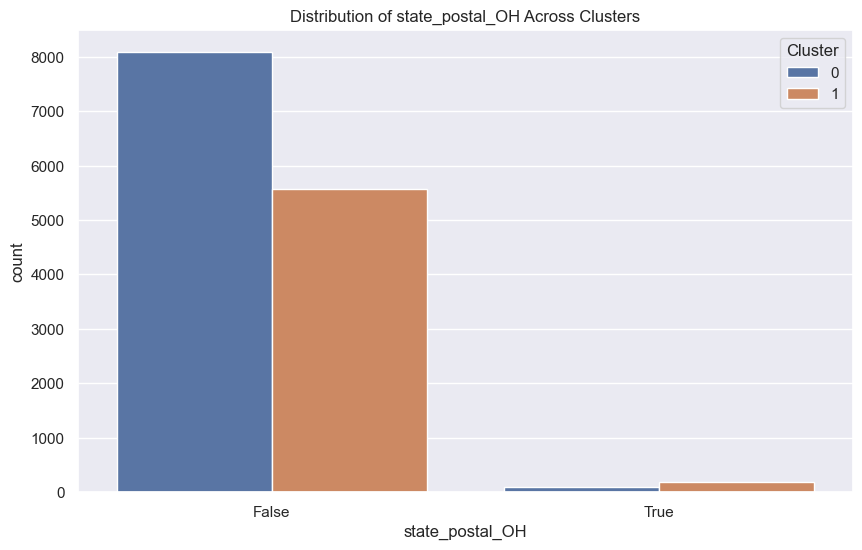

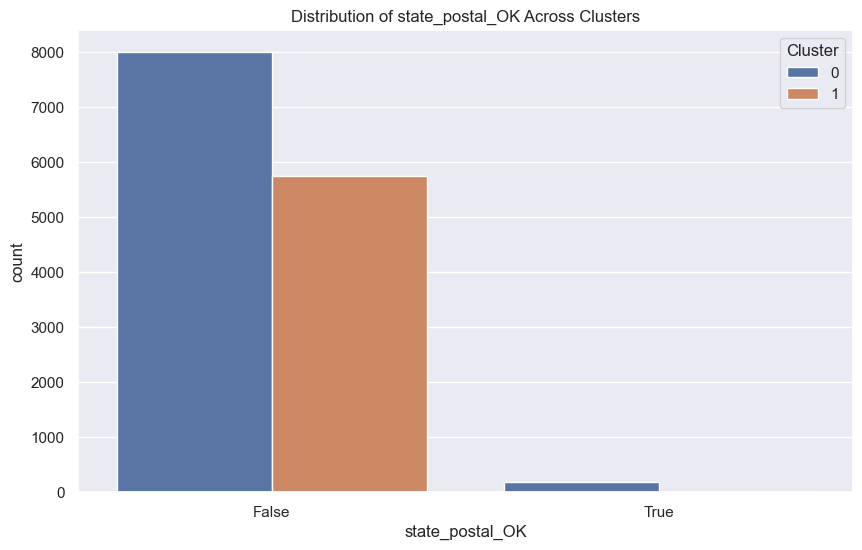

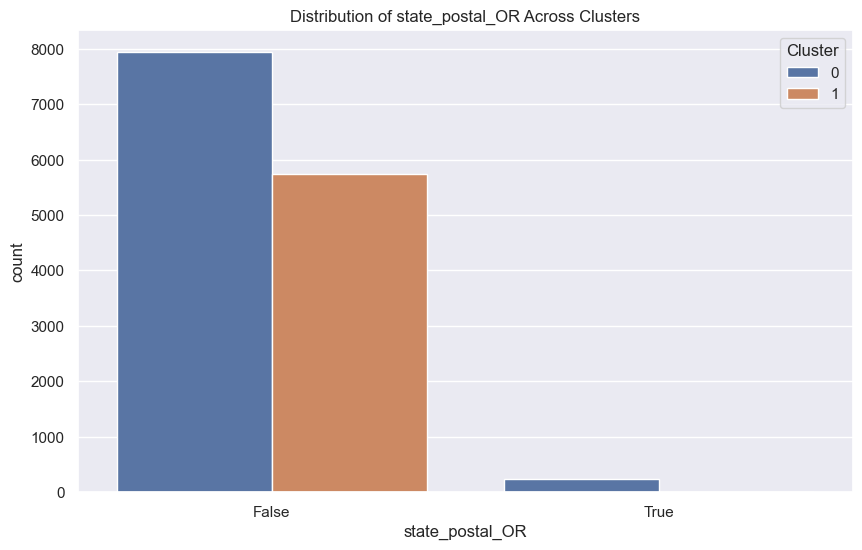

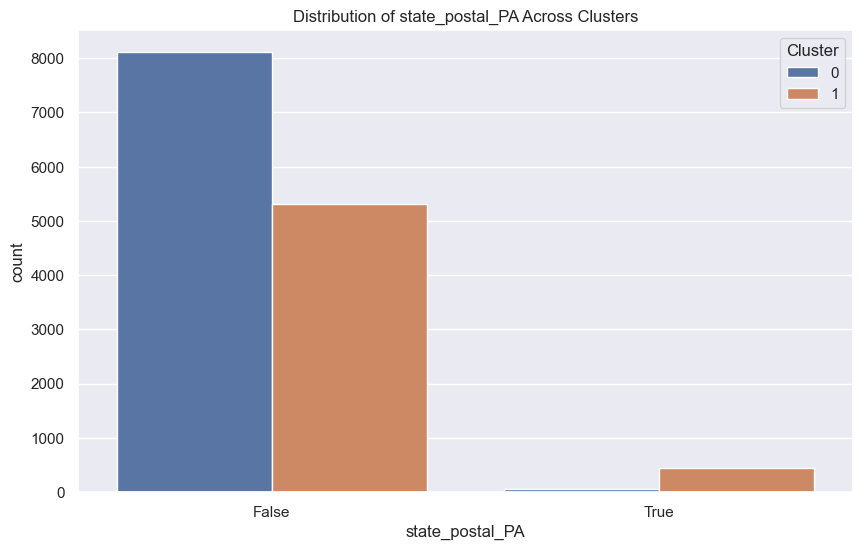

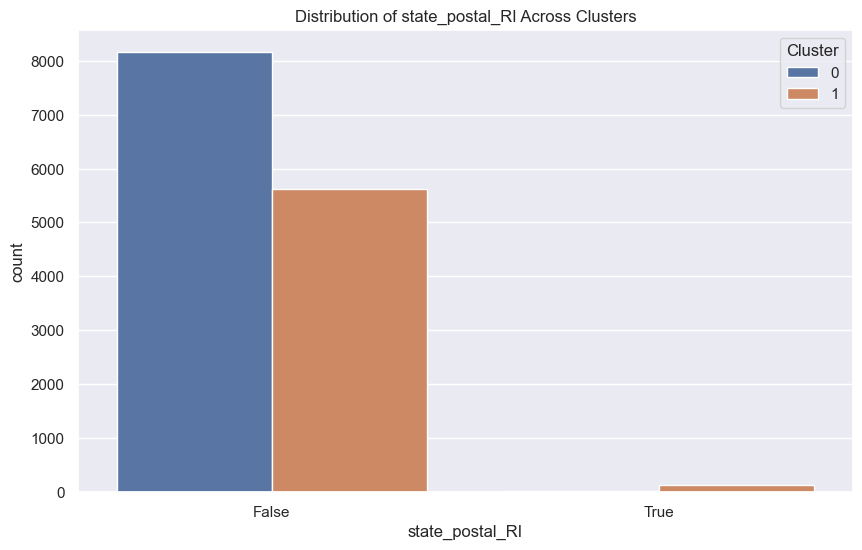

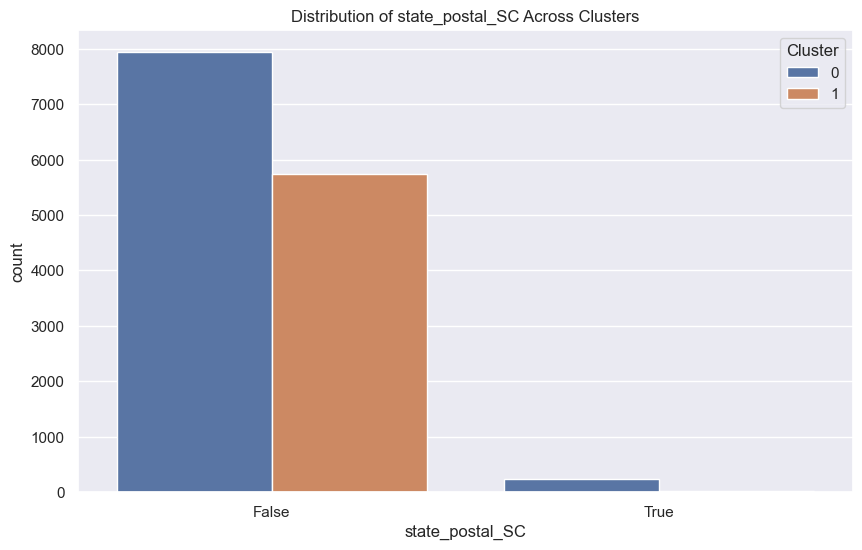

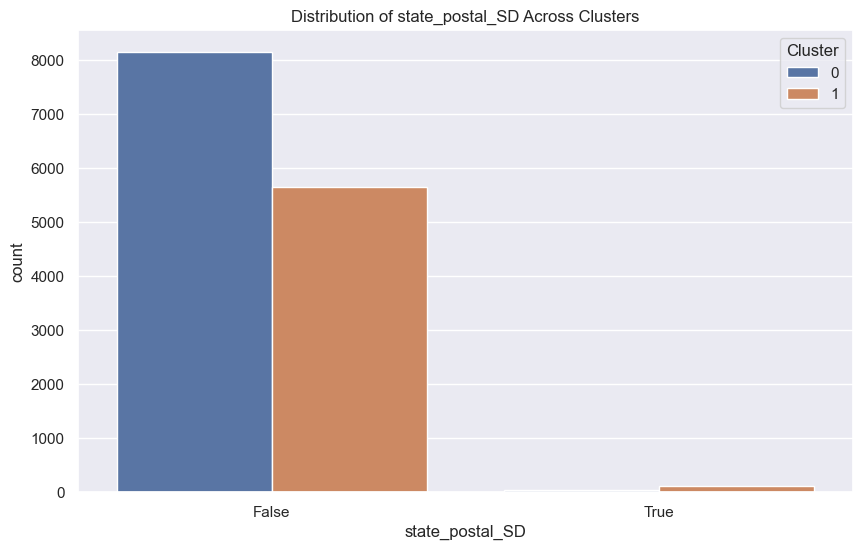

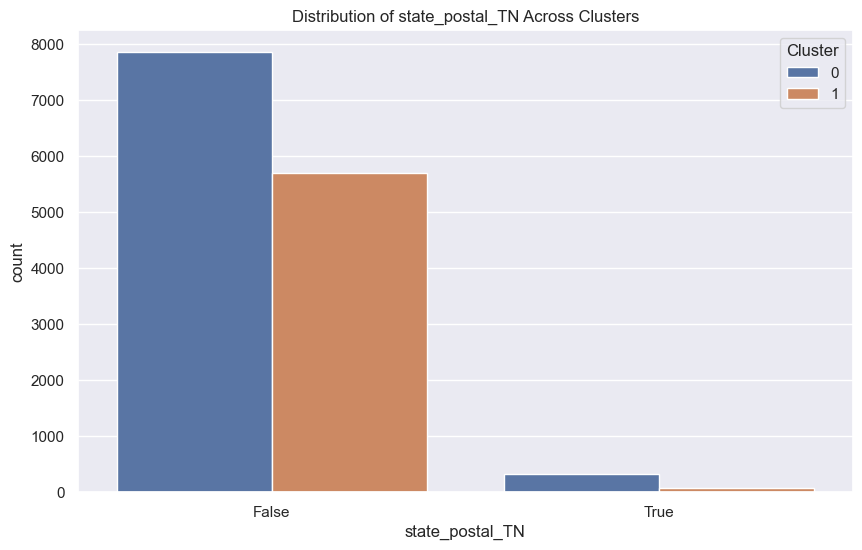

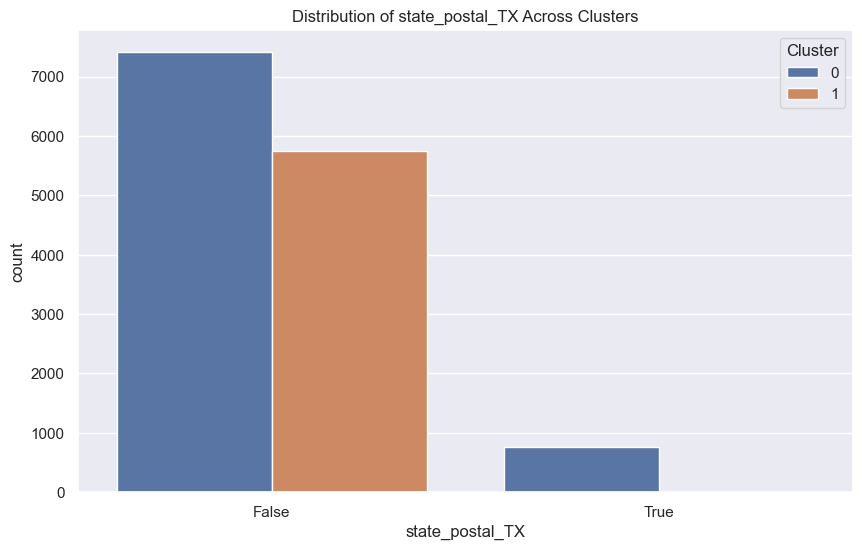

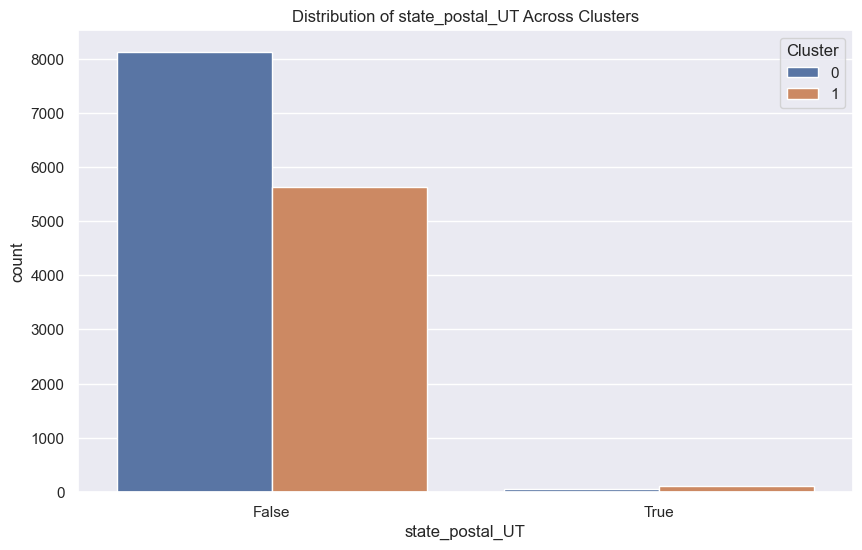

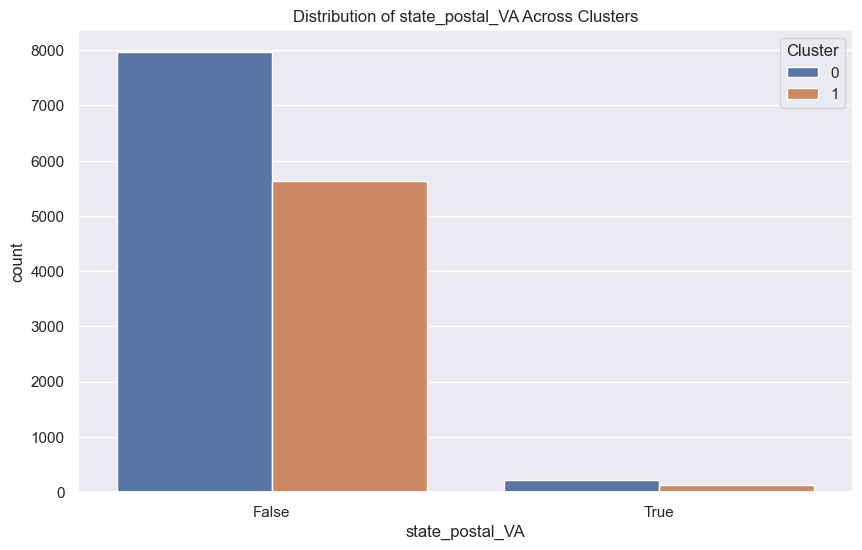

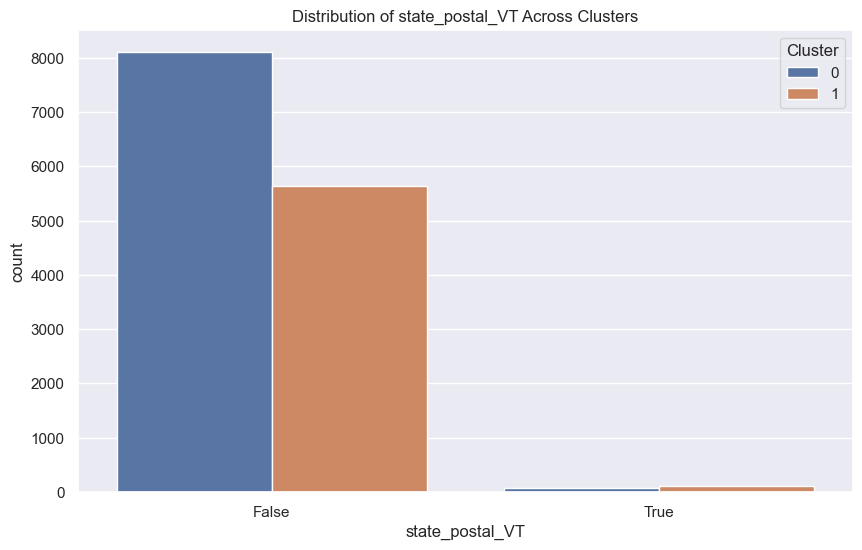

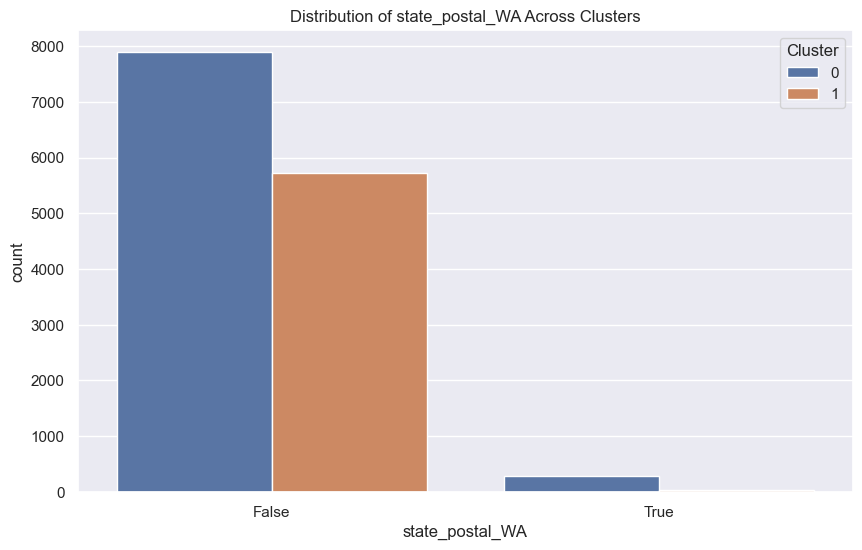

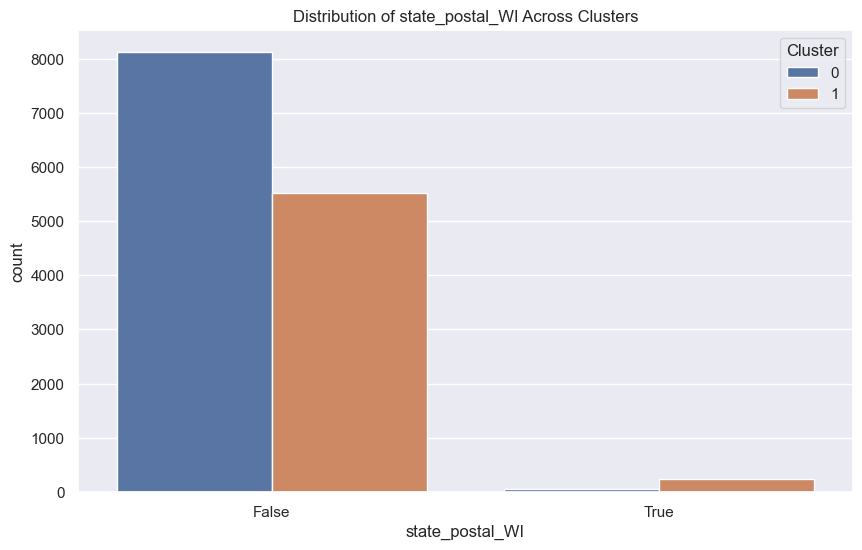

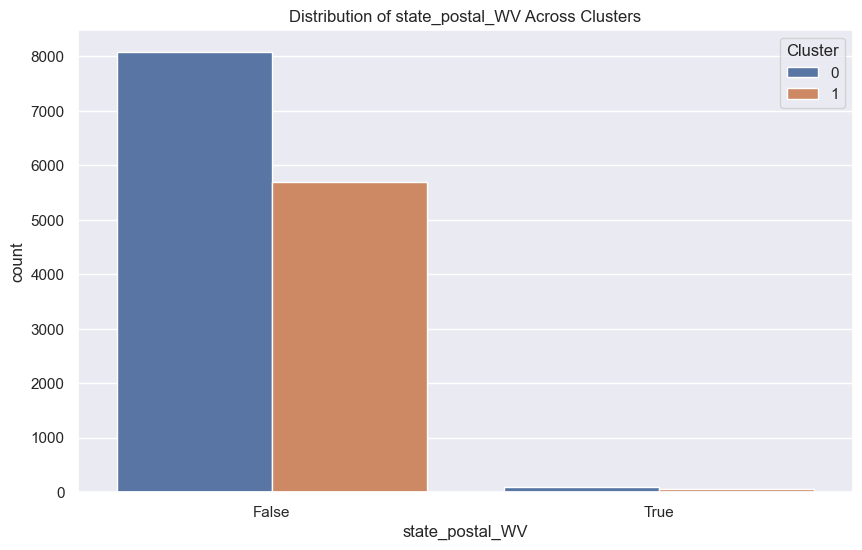

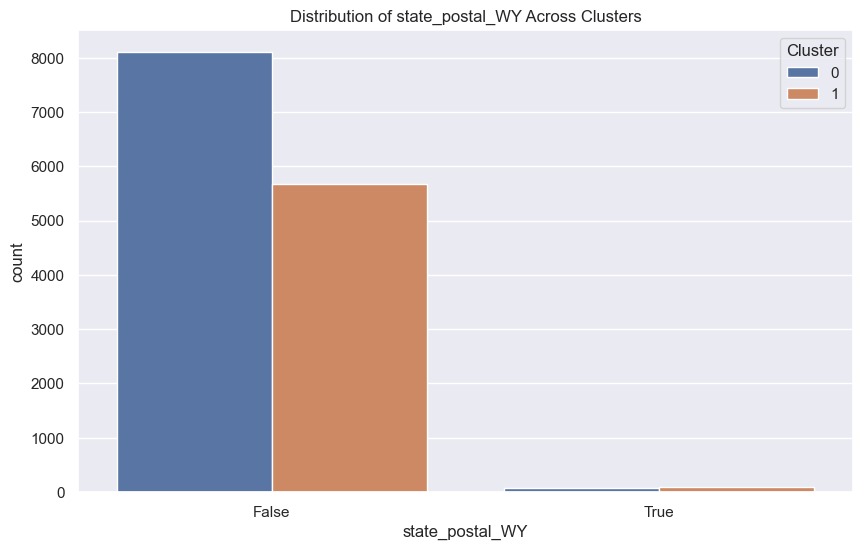

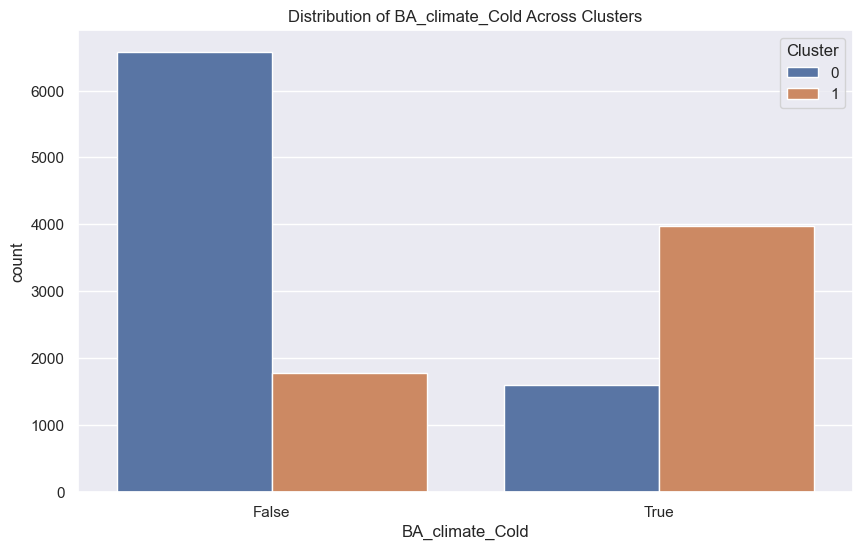

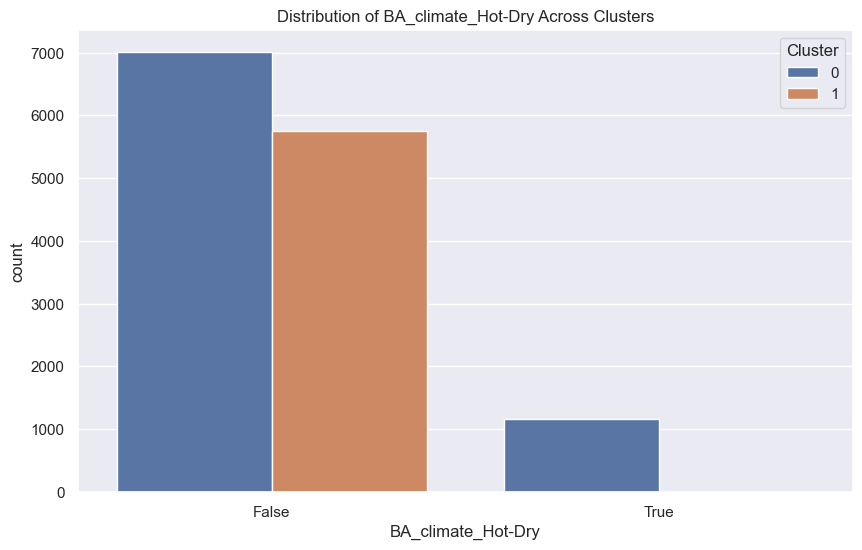

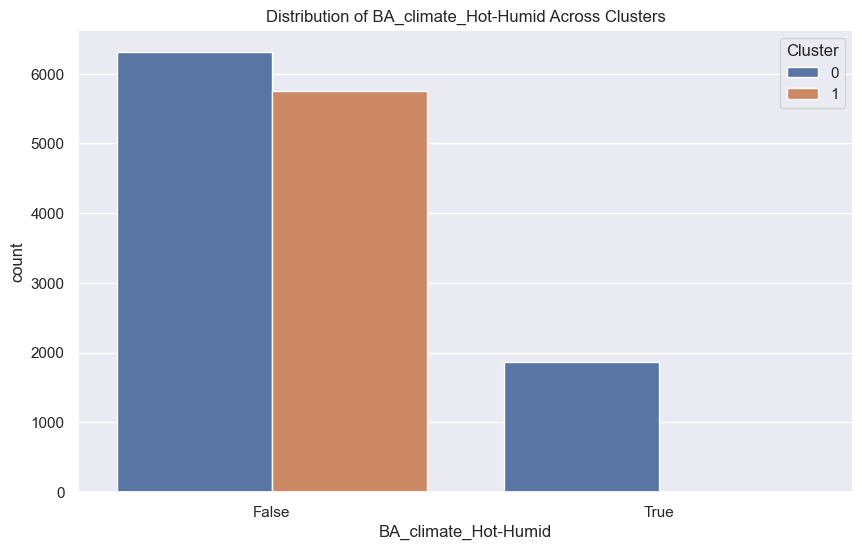

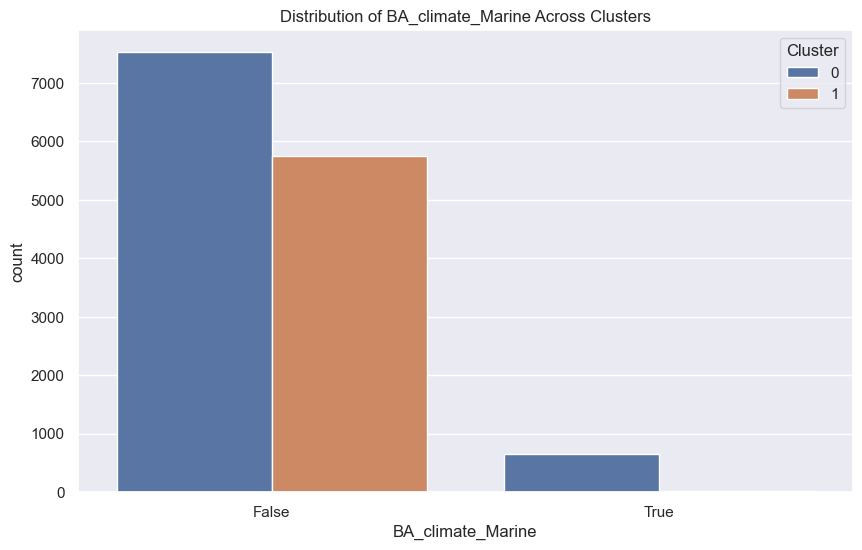

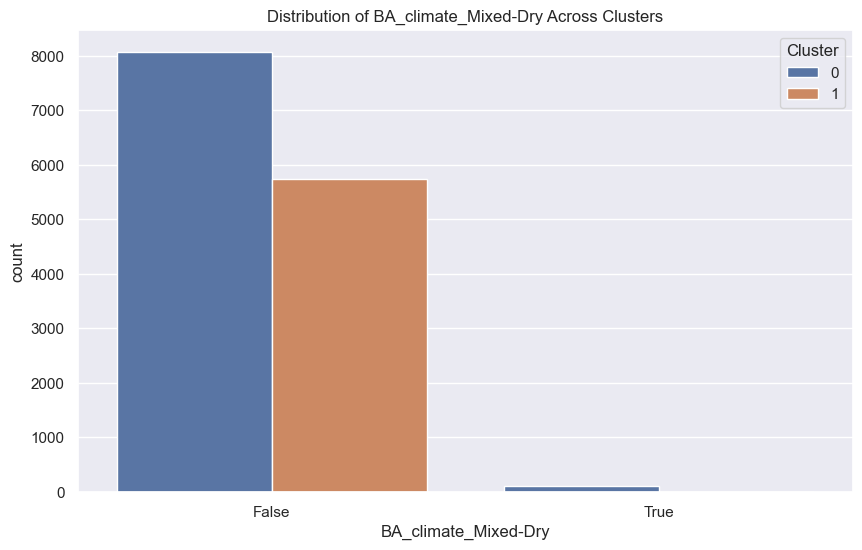

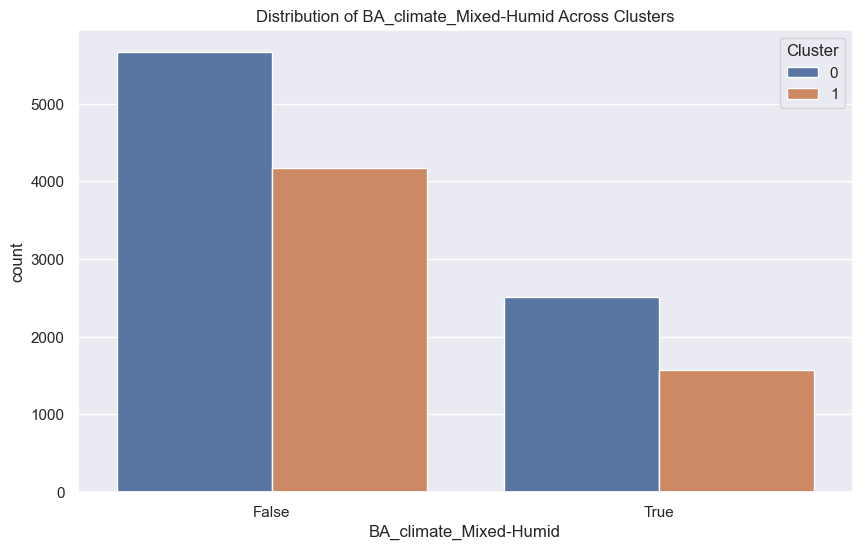

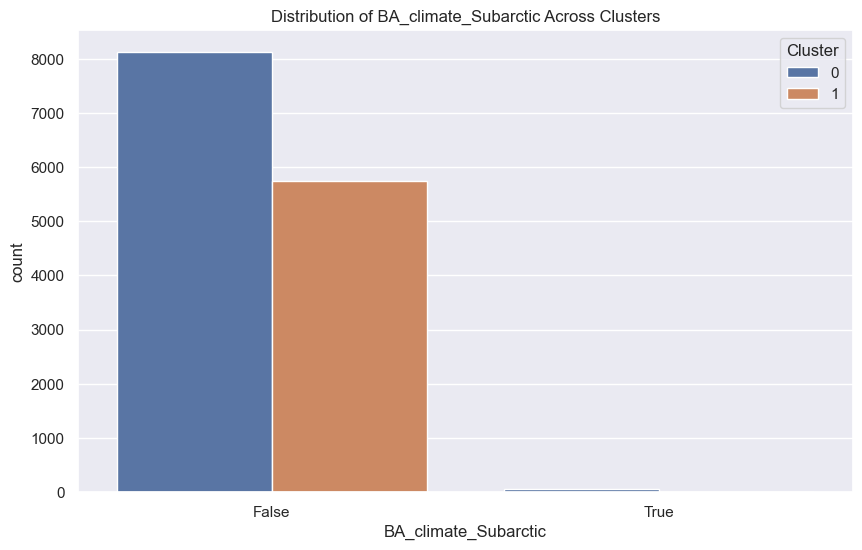

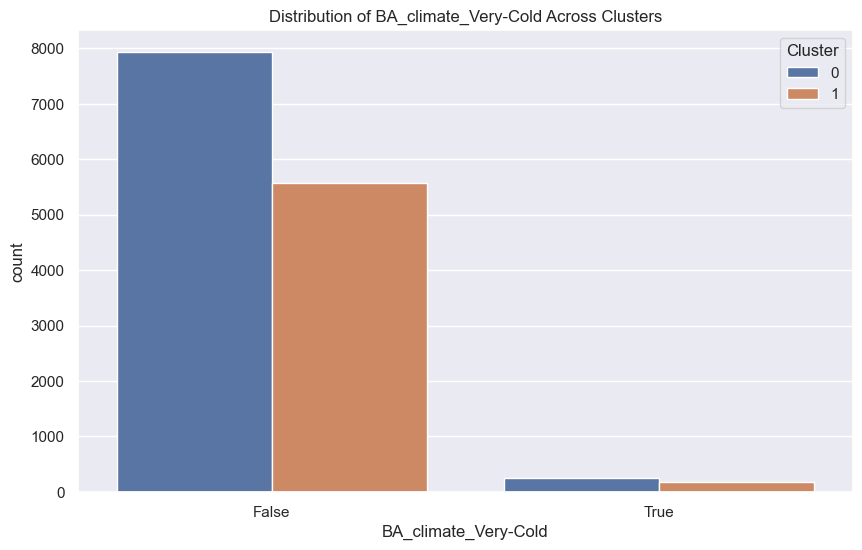

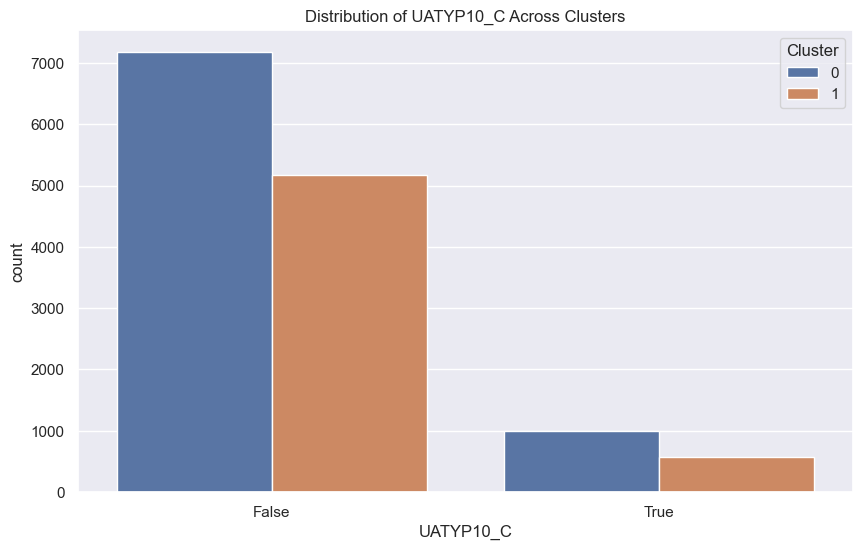

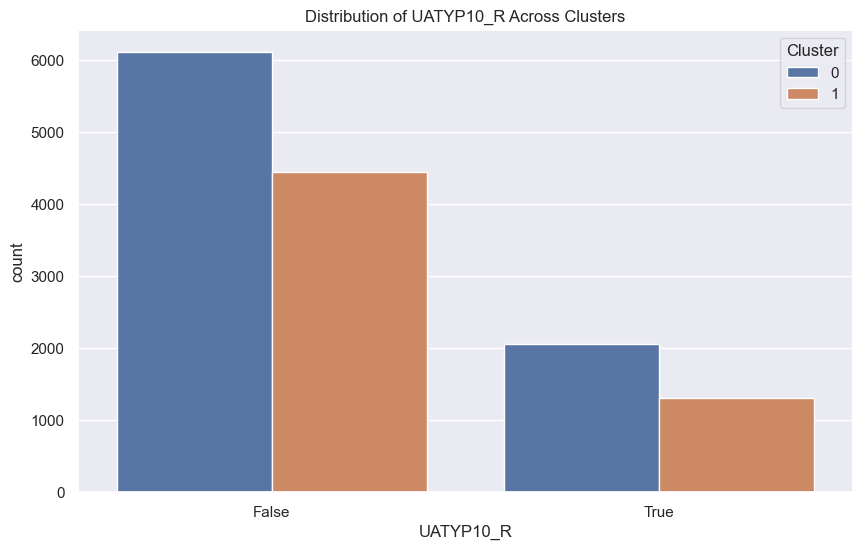

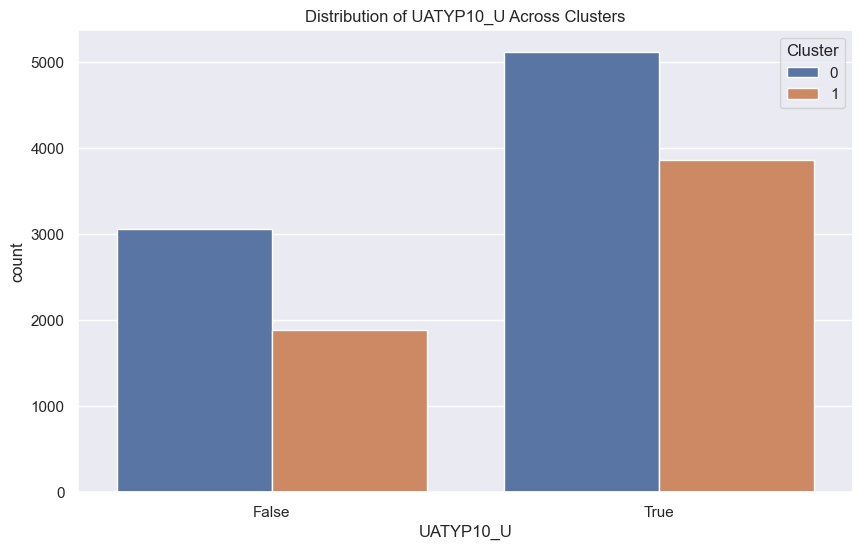

In [29]:
# Function to plot categorical distributions
def plot_categorical_distributions(data, cluster_labels, categorical_cols):
    data['Cluster'] = cluster_labels  # Add cluster labels to the data
    
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='Cluster', data=data)  # Plot categorical counts across clusters
        plt.title(f'Distribution of {col} Across Clusters')
        plt.show()

categorical_cols = subset_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Plot distributions for hierarchical clusters
plot_categorical_distributions(subset_df.copy(), hierarchical_labels, categorical_cols)
